In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sg
import matplotlib.pyplot as plt
import time as t 
from scipy.interpolate import make_smoothing_spline
from analysis_tools import *
from SIMHigh5 import SIMHigh5, merge_simh5

# Checks

### Time serie analysis

#### One timeserie

In [ ]:
load_list = [
    r'.\_ResultsH5\V03_timestorage0d05\testFlexibleMB300s.h5',

]

dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
}

H1 = merge_simh5([SIMHigh5(load_list[i],dynamic_keys, source="file") for i in range(0,len(load_list))])

T_min, T_max = 0, 300

H1_perm = H1.select_time_window(T_min, T_max)

In [ ]:
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]']
cond = H1_perm.df.coords['condition'].values[0]
fig,ax = plt.subplots(len(outputs),1, figsize=(15, 15), dpi=600)

for j,output in enumerate(outputs):
    time, serie = H1_perm.timeserie({'model':'FlexibleMB_C1P5', 'condition':cond, 'analysis':'Dynamic'}, output)
    ax[j].plot(time, serie)
    ax[j].set_title('Condition : ' + cond)
    ax[j].set_xlabel('Time (s)')
    ax[j].set_ylabel(output)

fig.tight_layout()

#### Multiple timeseries

In [ ]:
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]']
conds = H1_perm.df.coords['condition'].values
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(12, 6), dpi=600)

for i, cond in enumerate(conds):
    for j,output in enumerate(outputs):
        H1.comparePlot_timeseries(ax[i,j],'model',{'condition':cond, 'analysis':'Dynamic'},output)
        ax[i,j].set_title('Condition : ' + cond)
        ax[i,j].set_xlabel('Time (s)')
        ax[i,j].set_ylabel(output)

fig.tight_layout()

# Consistence with litterature

## Load everything

In [ ]:
load_list = [
    r'.\_ResultsH5\Baseline_\BaselineV02_Mann_Results.h5',
    r'.\_ResultsH5\Baseline_\BaselineV02_Kaimal_Results.h5'
]

dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                'line1//segment_1//node_1//Displacement in x - direction':'Xfairlead1 [m]',
                'line1//segment_1//node_1//Displacement in y - direction':'Yfairlead1 [m]',
                'line1//segment_1//node_1//Displacement in z - direction':'Zfairlead1 [m]',
                'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
                'nacelle/Wind velocity/Velocityinmaindirection':'WindVelocity [m/s]',
                'turbine/Rotor speed (rpm)':'RotorSpeed [rpm]',
                'tower//segment_1//element_1//Mom_ about local y-axis, end 1':'ForeAftBendingMoment [Nm]',
                # 'turbine/Incoming wind speed X-dir in shaft system':'WindVelocity [m/s]',
                }

H1 = merge_simh5([SIMHigh5(load_list[i],dynamic_keys, source="file") for i in range(0,len(load_list))])

T_trans = 900
H1_perm = H1.skip_transient(T_trans)

## Turbulent wind

### Timeseries of the turbulent wind

In [ ]:
outputs = ['WindVelocity [m/s]']
conds = H1_perm.df.coords['condition'].values[:2]
fig,ax = plt.subplots(len(conds),len(outputs), figsize=(len(conds)*5, len(outputs)*5), dpi=600)

for i, cond in enumerate(conds):
    for j,output in enumerate(outputs):
        H1_perm.comparePlot_timeseries(ax[i],'condition',{'model':'Baseline', 'analysis':'Dynamic'},output)
        ax[i].set_title('Condition : ' + cond)

fig.tight_layout()

### Mean and standard deviation of Wind and Rotor speed

In [ ]:
outputs = ['WindVelocity [m/s]', 'RotorSpeed [rpm]']
conds = H1_perm.df.coords['condition'].values#[:2]
x_name = 'U_hub (m/s)'
x_vals = np.array([8,14])

print('create below a dictonary with the conditions associated with the correspondant value of x_val')
print('Here are the conditions : ')
print(conds)

In [ ]:
dict_cond_x = {'KaimalSet_1':8, 'KaimalSet_10':14, 'KaimalSet_11':14, 'KaimalSet_12':14, 'KaimalSet_2':8,
 'KaimalSet_3':8, 'KaimalSet_4':8, 'KaimalSet_5':8, 'KaimalSet_6':8, 'KaimalSet_7':14,
 'KaimalSet_8':14, 'KaimalSet_9':14, 'MannSet_1':8, 'MannSet_10':14, 'MannSet_11':14,
 'MannSet_12':14, 'MannSet_2':8, 'MannSet_3':8, 'MannSet_4':8, 'MannSet_5':8, 'MannSet_6':8,
 'MannSet_7':14, 'MannSet_8':14, 'MannSet_9':14}

dict_cond_colors = {'KaimalSet_1':'cyan', 'KaimalSet_10':'blue', 'KaimalSet_11':'blue', 'KaimalSet_12':'blue', 'KaimalSet_2':'cyan',
 'KaimalSet_3':'cyan', 'KaimalSet_4':'cyan', 'KaimalSet_5':'cyan', 'KaimalSet_6':'cyan', 'KaimalSet_7':'blue',
 'KaimalSet_8':'blue', 'KaimalSet_9':'blue', 'MannSet_1':'red', 'MannSet_10':'orange', 'MannSet_11':'orange',
 'MannSet_12':'orange', 'MannSet_2':'red', 'MannSet_3':'red', 'MannSet_4':'red', 'MannSet_5':'red', 'MannSet_6':'red',
 'MannSet_7':'orange', 'MannSet_8':'orange', 'MannSet_9':'orange'}

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12, 8), dpi=600)

l = "IEC standard"
expected_sigmaU = lambda u : 0.14*(0.75*u + 5.6) # From IEC 61400-1:2019

leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond}, show = False)
    leg.append(cond)
    for j, output in enumerate(outputs):
        # print('Mean of ' + output + ' =' + str(run[output].mean()))
        ax[0,j].plot(dict_cond_x[cond], run[output].mean(), color = dict_cond_colors[cond],marker='.')
        ax[1,j].plot(dict_cond_x[cond], run[output].std(), color = dict_cond_colors[cond],marker='.')
        ax[0,j].set_xlabel(x_name)
        ax[0,j].set_ylabel('Mean of ' + output)
        ax[1,j].set_xlabel(x_name)
        ax[1,j].set_ylabel('Std of ' + output)

ax[1,0].plot(x_vals, expected_sigmaU(x_vals), color = 'green',ls='-')
fig.legend(conds, ncol = 6, loc = 'upper center', bbox_to_anchor = (0.5, 1.05 ))

## Degrees of Freedom

In [ ]:
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]']
fig,ax = plt.subplots(2,len(outputs), figsize=(16,6), dpi=600)

# Results from Bachynski / Eliasen
surge5MW = [
    {'Kaimal_TurbulentWindSet':1.3, 'Mann_TurbulentWindSet':1.1},
    {'Kaimal_TurbulentWindSet':1.3, 'Mann_TurbulentWindSet':1.25}
]
pitch5MW = [
    {'Kaimal_TurbulentWindSet':1.2, 'Mann_TurbulentWindSet':1},
    {'Kaimal_TurbulentWindSet':2.7, 'Mann_TurbulentWindSet':2.55}
]
yaw5MW = [
    {'Kaimal_TurbulentWindSet':0.45, 'Mann_TurbulentWindSet':0.6},
    {'Kaimal_TurbulentWindSet':0.65, 'Mann_TurbulentWindSet':0.9}
]
surge10MW = [
    {'Kaimal_TurbulentWindSet':2.1, 'Mann_TurbulentWindSet':1.75},
    {'Kaimal_TurbulentWindSet':2, 'Mann_TurbulentWindSet':1.9}
]
pitch10MW = [
    {'Kaimal_TurbulentWindSet':1.1, 'Mann_TurbulentWindSet':0.9},
    {'Kaimal_TurbulentWindSet':2.3, 'Mann_TurbulentWindSet':2}
]
yaw10MW = [
    {'Kaimal_TurbulentWindSet':0.55, 'Mann_TurbulentWindSet':0.75},
    {'Kaimal_TurbulentWindSet':1, 'Mann_TurbulentWindSet':1.3}
]
litterature = {
    'Surge [m]': [surge5MW, surge10MW], 
    'Pitch [deg]': [pitch5MW, pitch10MW],
    'Yaw [deg]': [yaw5MW, yaw10MW],
}

leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond}, show = False)
    leg.append(cond)
    for j, output in enumerate(outputs):
        ax[0,j].plot(dict_cond_x[cond], run[output].mean(), color = dict_cond_colors[cond],marker='.')
        ax[1,j].plot(dict_cond_x[cond], run[output].std(), color = dict_cond_colors[cond],marker='.')
        ax[0,j].set_xlabel(x_name)
        ax[0,j].set_ylabel('Mean of ' + output)
        ax[1,j].set_xlabel(x_name)
        ax[1,j].set_ylabel('Std of ' + output)

        if dict_cond_x[cond] == 8:
            ax[1,j].plot(dict_cond_x[cond], litterature[output][0][0]['Kaimal_TurbulentWindSet'], color = 'green', marker='x')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][1][0]['Kaimal_TurbulentWindSet'], color = 'green', marker='+')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][0][0]['Mann_TurbulentWindSet'], color = 'green', marker='x')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][1][0]['Mann_TurbulentWindSet'], color = 'green', marker='+')
        else:
            ax[1,j].plot(dict_cond_x[cond], litterature[output][0][1]['Kaimal_TurbulentWindSet'], color = 'green', marker='x')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][1][1]['Kaimal_TurbulentWindSet'], color = 'green', marker='+')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][0][1]['Mann_TurbulentWindSet'], color = 'green', marker='x')
            ax[1,j].plot(dict_cond_x[cond], litterature[output][1][1]['Mann_TurbulentWindSet'], color = 'green', marker='+')

# DOF Motions Analysis

## Load datas

In [2]:

load_list = [
    r'.\_ResultsH5\V03_timestorage0d05\angle_var_all_windstypes_8ms.h5'
]

load_list = [
    r'.\_ResultsH5\Results_Irregular.h5'
]

dynamic_keys = {
                'platform//Global total position//XGtranslationTotalmotion':'Surge [m]',
                'platform//Global total position//YGtranslationTotalmotion':'Sway [m]',
                'platform//Global total position//ZGtranslationTotalmotion':'Heave [m]',
                'platform//Global total position//XLrotationTotalmotion':'Roll [deg]',
                'platform//Global total position//YLrotationTotalmotion':'Pitch [deg]',
                'platform//Global total position//ZGrotationTotalmotion':'Yaw [deg]',
                # 'line1//segment_1//node_1//Displacement in x - direction':'Xfairlead1 [m]',
                # 'line1//segment_1//node_1//Displacement in y - direction':'Yfairlead1 [m]',
                # 'line1//segment_1//node_1//Displacement in z - direction':'Zfairlead1 [m]',
                # 'Origo/Wave elevation/Totalwaveelevation':'Elevation [m]',
                'nacelle/Wind velocity/Velocityinmaindirection':'WindVelocity [m/s]',
                'turbine/Rotor speed (rpm)':'RotorSpeed [rpm]',
                'tower//segment_1//element_1//Mom_ about local y-axis, end 1':'ForeAftBendingMoment [Nm]',
                'line1//segment_4//node_5//Displacement in z - direction':'VerticalMotion_N5L1 [m]',
                'line1//segment_4//node_6//Displacement in z - direction':'VerticalMotion_N6L1 [m]',
                'line1//segment_4//node_7//Displacement in z - direction':'VerticalMotion_N7L1 [m]',
                'line1//segment_4//node_8//Displacement in z - direction':'VerticalMotion_N8L1 [m]',
                # 'turbine/Incoming wind speed X-dir in shaft system':'WindVelocity [m/s]',
                }


H1 = merge_simh5([SIMHigh5(load_list[i],dynamic_keys, source="file", debug = False, silent = False) for i in range(0,len(load_list))])


 SUCCESS IMPORTING DATASET 
------------------------------
 THIS IS THE IMPORTED DATASET
<xarray.Dataset> Size: 467MB
Dimensions:                    (model: 1, condition: 4, analysis: 2,
                                time: 800001)
Coordinates:
  * model                      (model) <U25 100B 'INO_OptiFLEX22MW_Baseline'
  * condition                  (condition) <U19 304B 'IrregularAnalysis_1' .....
  * analysis                   (analysis) <U7 56B 'Static' 'Dynamic'
  * time                       (time) float64 6MB 0.0 0.005 0.01 ... 4e+03 4e+03
Data variables:
    Surge [m]                  (model, condition, analysis, time) float64 51MB ...
    Sway [m]                   (model, condition, analysis, time) float64 51MB ...
    Heave [m]                  (model, condition, analysis, time) float64 51MB ...
    Roll [deg]                 (model, condition, analysis, time) float64 51MB ...
    Pitch [deg]                (model, condition, analysis, time) float64 51MB ...
    Yaw [deg]  

## Check timeserie

In [ ]:
outputs = ['Surge [m]', 'RotorSpeed [rpm]']
fig,ax = plt.subplots(len(outputs),1, figsize=(15, 15), dpi=600)
for j,output in enumerate(outputs):
    cond = H1.conds[0]
    time, serie = H1.timeserie({'model':'Baseline', 'condition':cond, 'analysis':'Dynamic'}, output, show=False)
    ax[j].plot(time, serie)
    ax[j].set_title('Condition : ' + cond)
    ax[j].set_xlabel('Time (s)')
    ax[j].set_ylabel(output)

fig.tight_layout()

In [ ]:
outputs = ['Surge [m]', 'Pitch [deg]', 'Yaw [deg]', 'WindVelocity [m/s]']

fig,ax = plt.subplots(1,1, figsize=(15, 15), dpi=600)
H1.comparePlot_timeseries(ax, 'condition', {'model':'Baseline', 'analysis':'Dynamic'}, 'VerticalMotion_N7L1 [m]')

## Decay test

In [ ]:

dict_cond_colors = {
    'DecaySet_Rotation_1':'blue', 
    'DecaySet_Rotation_2':'blue',
    'DecaySet_Translation_1':'blue',
    'DecaySet_Translation_2':'blue',
}

outputs = [
    'Surge [m]',
    'Sway [m]',
    'Heave [m]',
    'Roll [deg]',
    'Pitch [deg]',
    'Yaw [deg]',
    # 'ForeAftBendingMoment [Nm]'
]

focus = {
    'model':'INO_OptiFLEX22MW_Baseline',
    'condition':'DecaySet_Rotation_2',
    'analysis':'Dynamic',
    'output':'Pitch [deg]'
}

H1_perm = H1.select_time_window(210, 2000)

h = H1_perm.selection(
    {
        'model':focus['model'],
        'condition':focus['condition'],
        'analysis':focus['analysis']
    }
)

fig, ax, res = compare_decay_tests(h,outputs,focus,colors=dict_cond_colors,styles={},labels={},figsize=(16,7))



In [ ]:
# Example data
P, Q, amp, y, Tn = res[focus['condition']][focus['output']]

plt.figure(figsize=(8, 6))

# Scatter data points
plt.plot(amp, y, 'or', label='Data points')

# Regression line
plt.plot(amp, P + Q * np.array(amp), ls='-', color='blue',
         label=fr'Regression: $y = {P:.2f} + {Q:.2f}x$')

# Labels with LaTeX
plt.xlabel(r'$\bar{A}$', fontsize=14)
plt.ylabel(r'$\Delta \varphi / \bar{A}$', fontsize=14)

# Legend with nice font
plt.legend(fontsize=12, loc='best')

# Grid and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('PQ Analysis of ' + focus['output'] + r': Fit of $\Delta \varphi / \bar{A}$ vs $\bar{A}$', fontsize=16)

plt.tight_layout()
plt.show()


## Spectral analysis

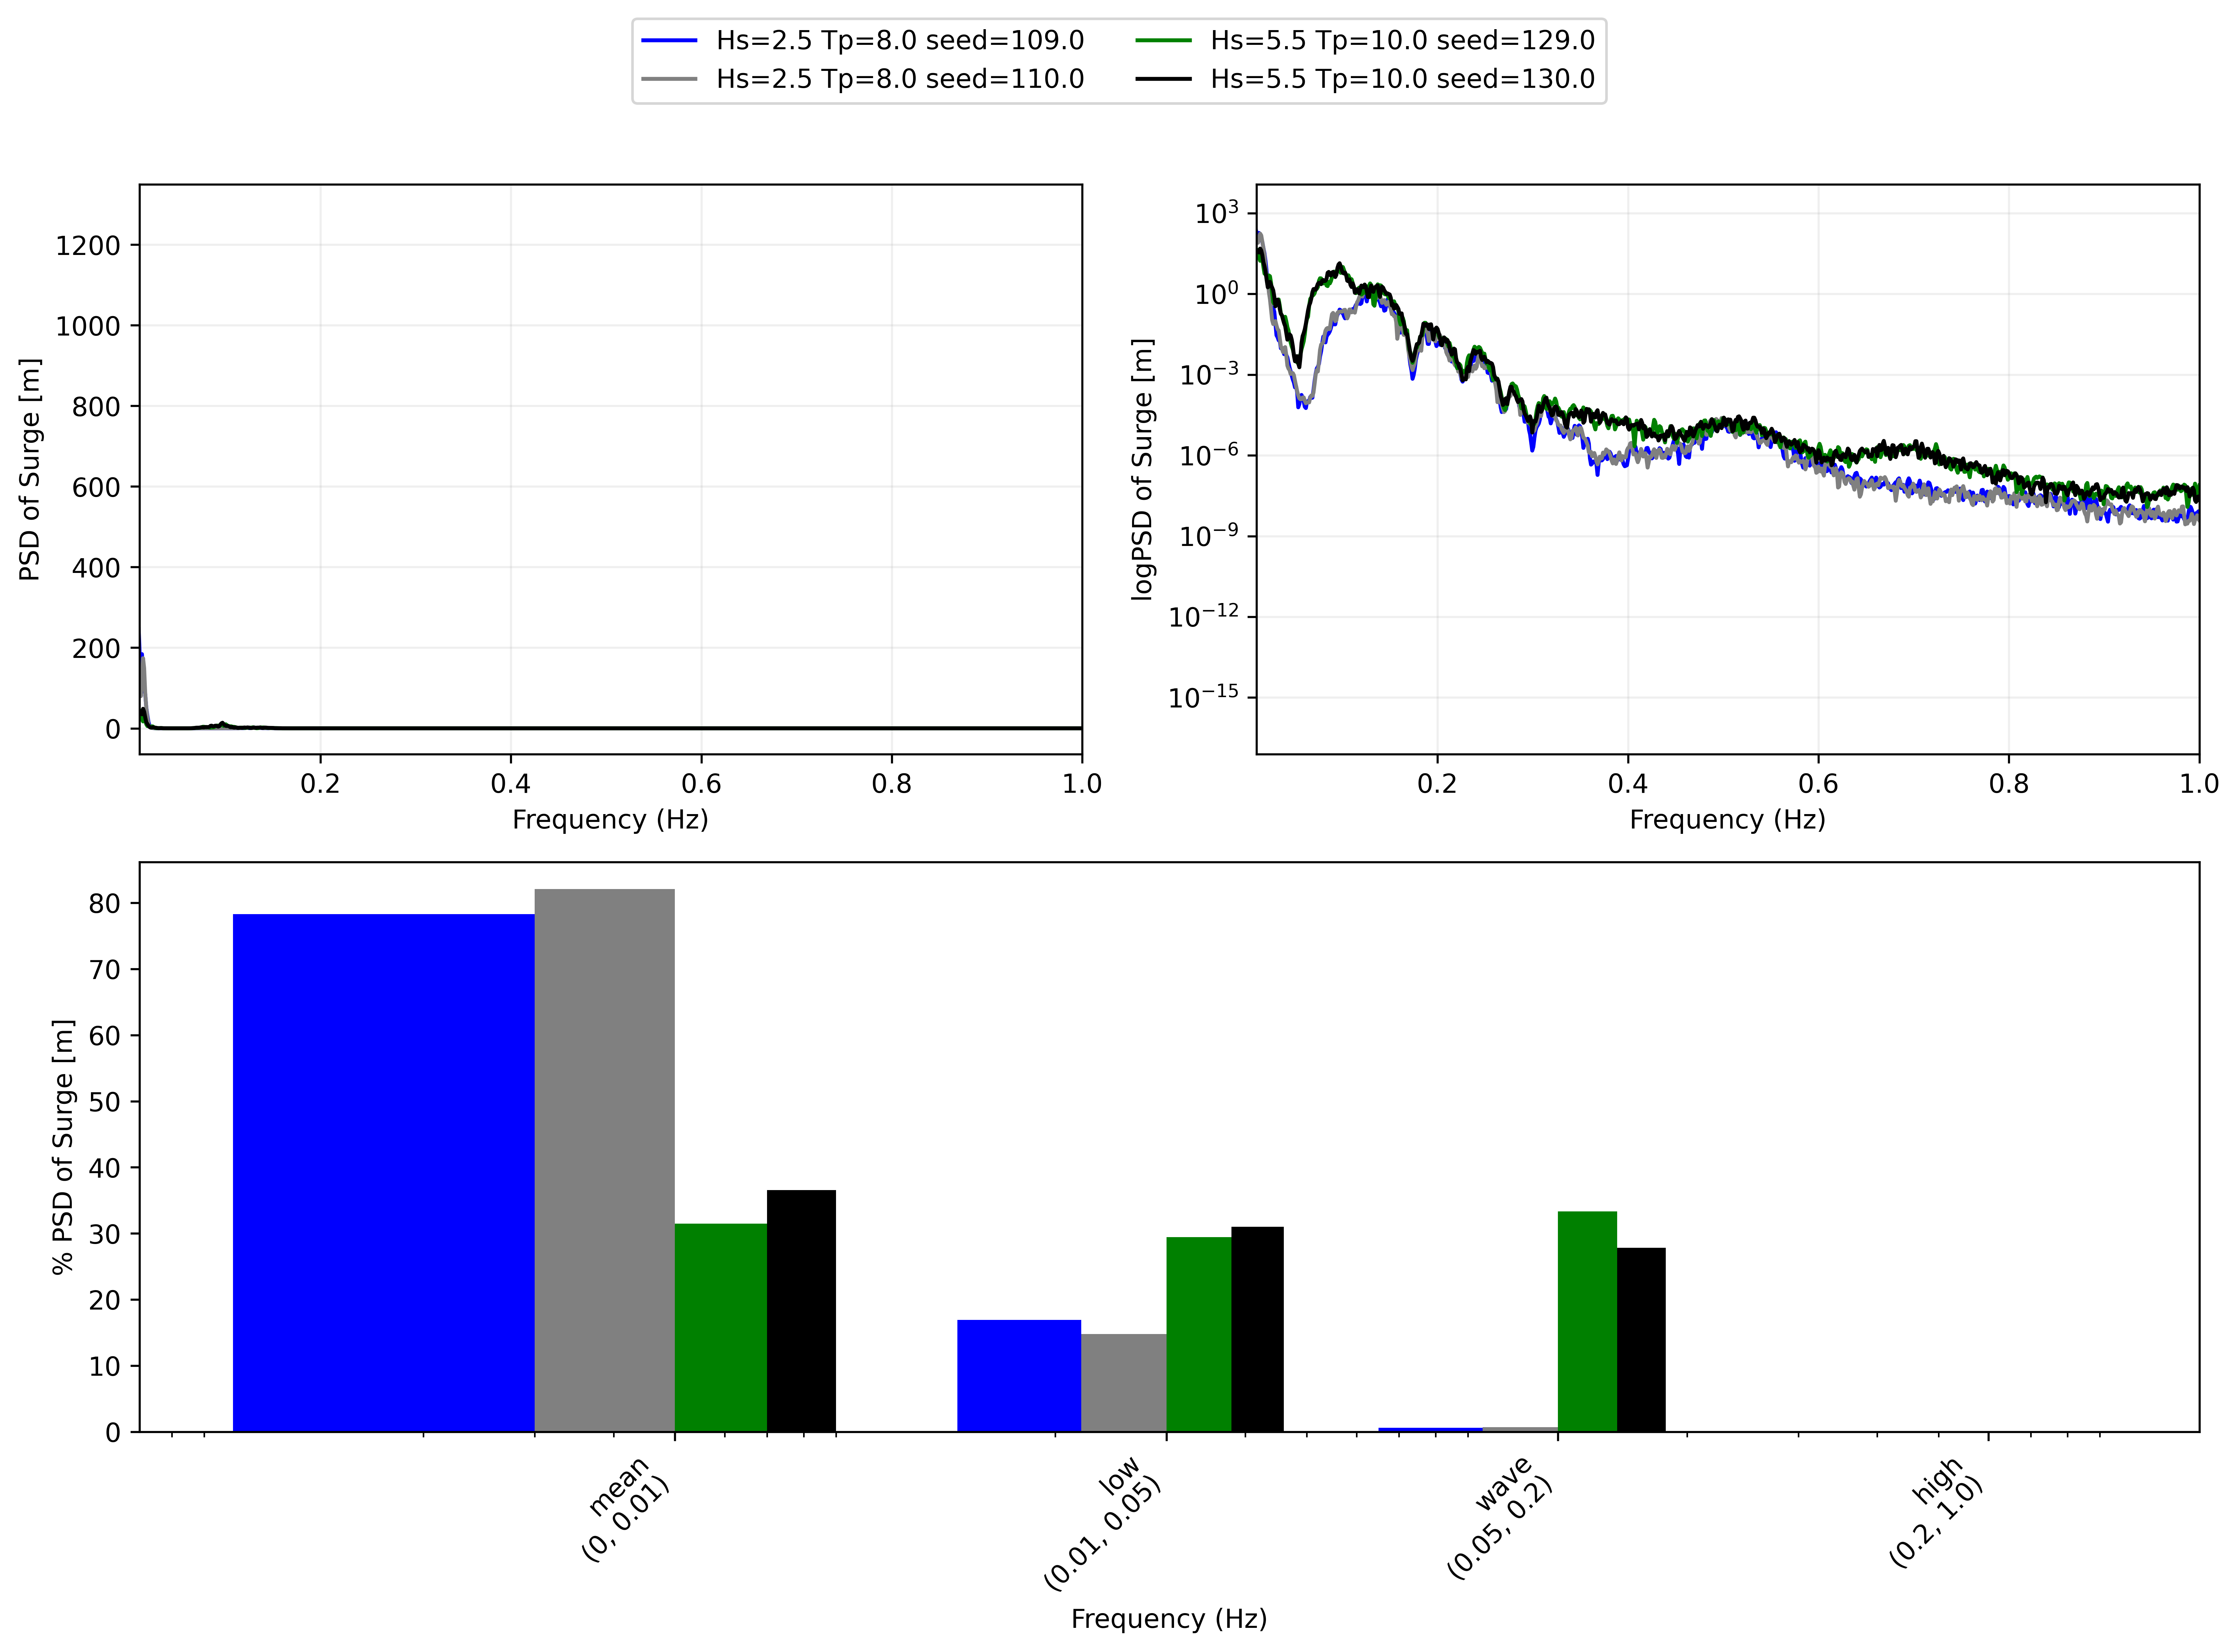

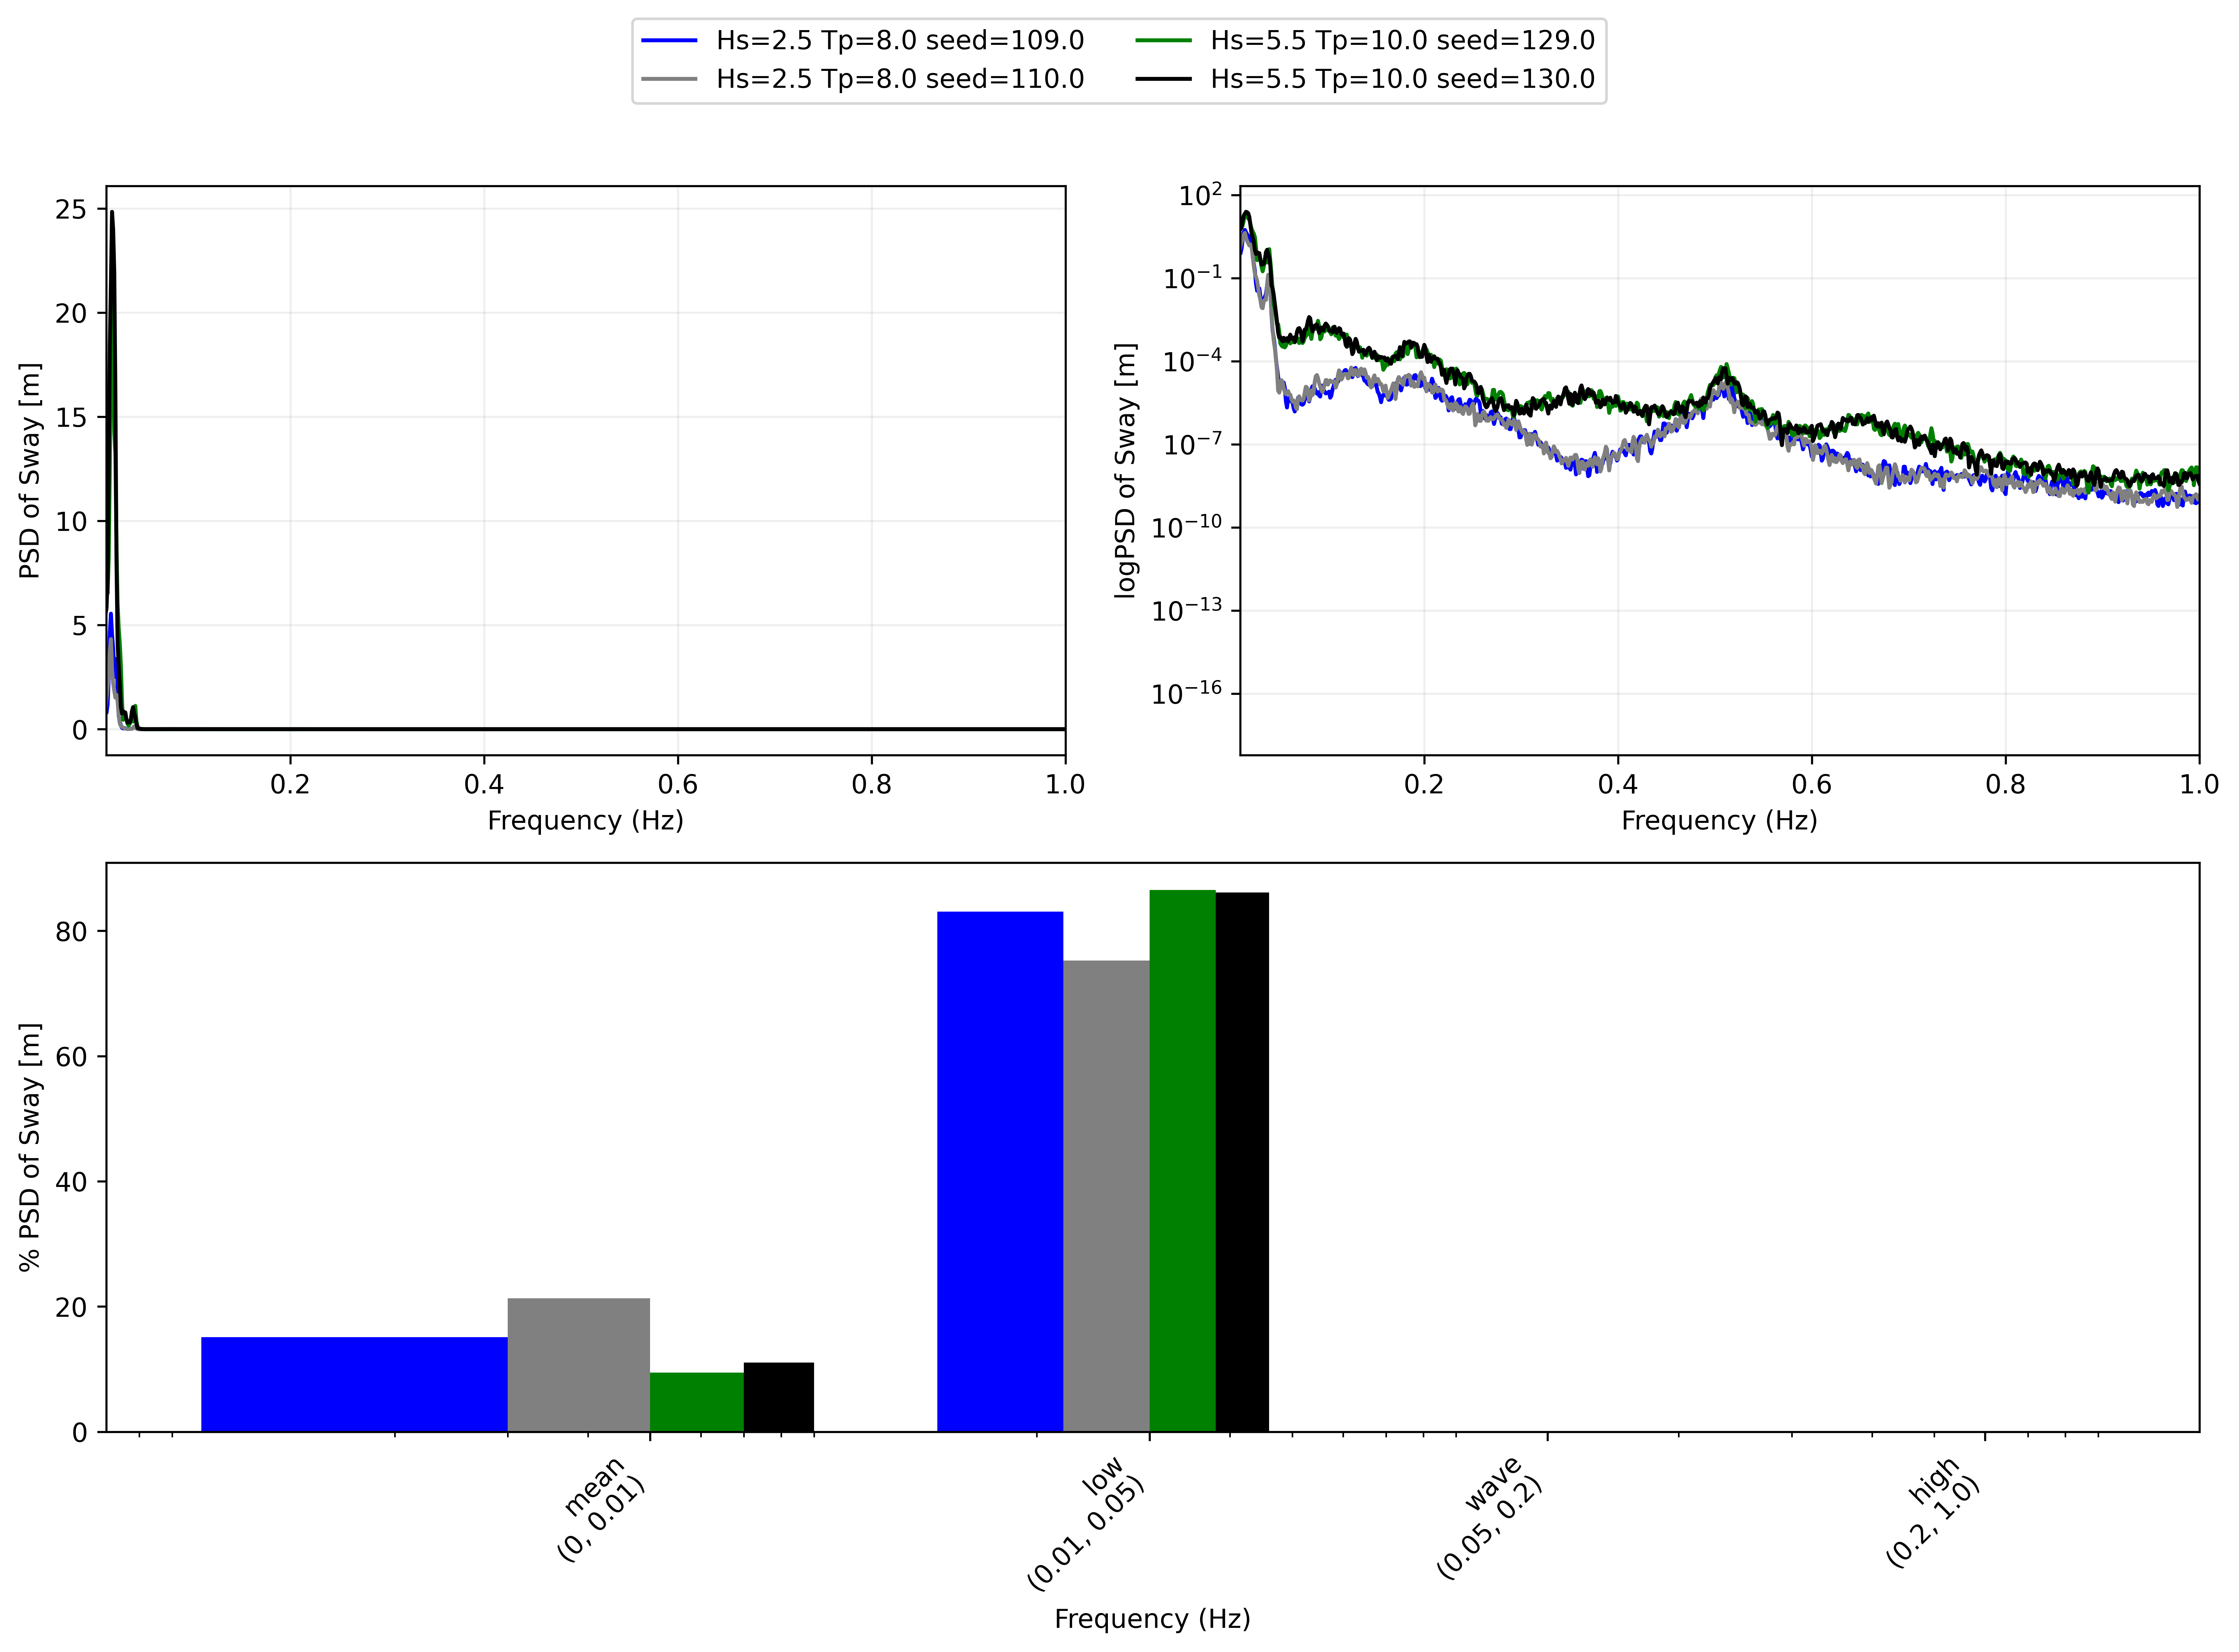

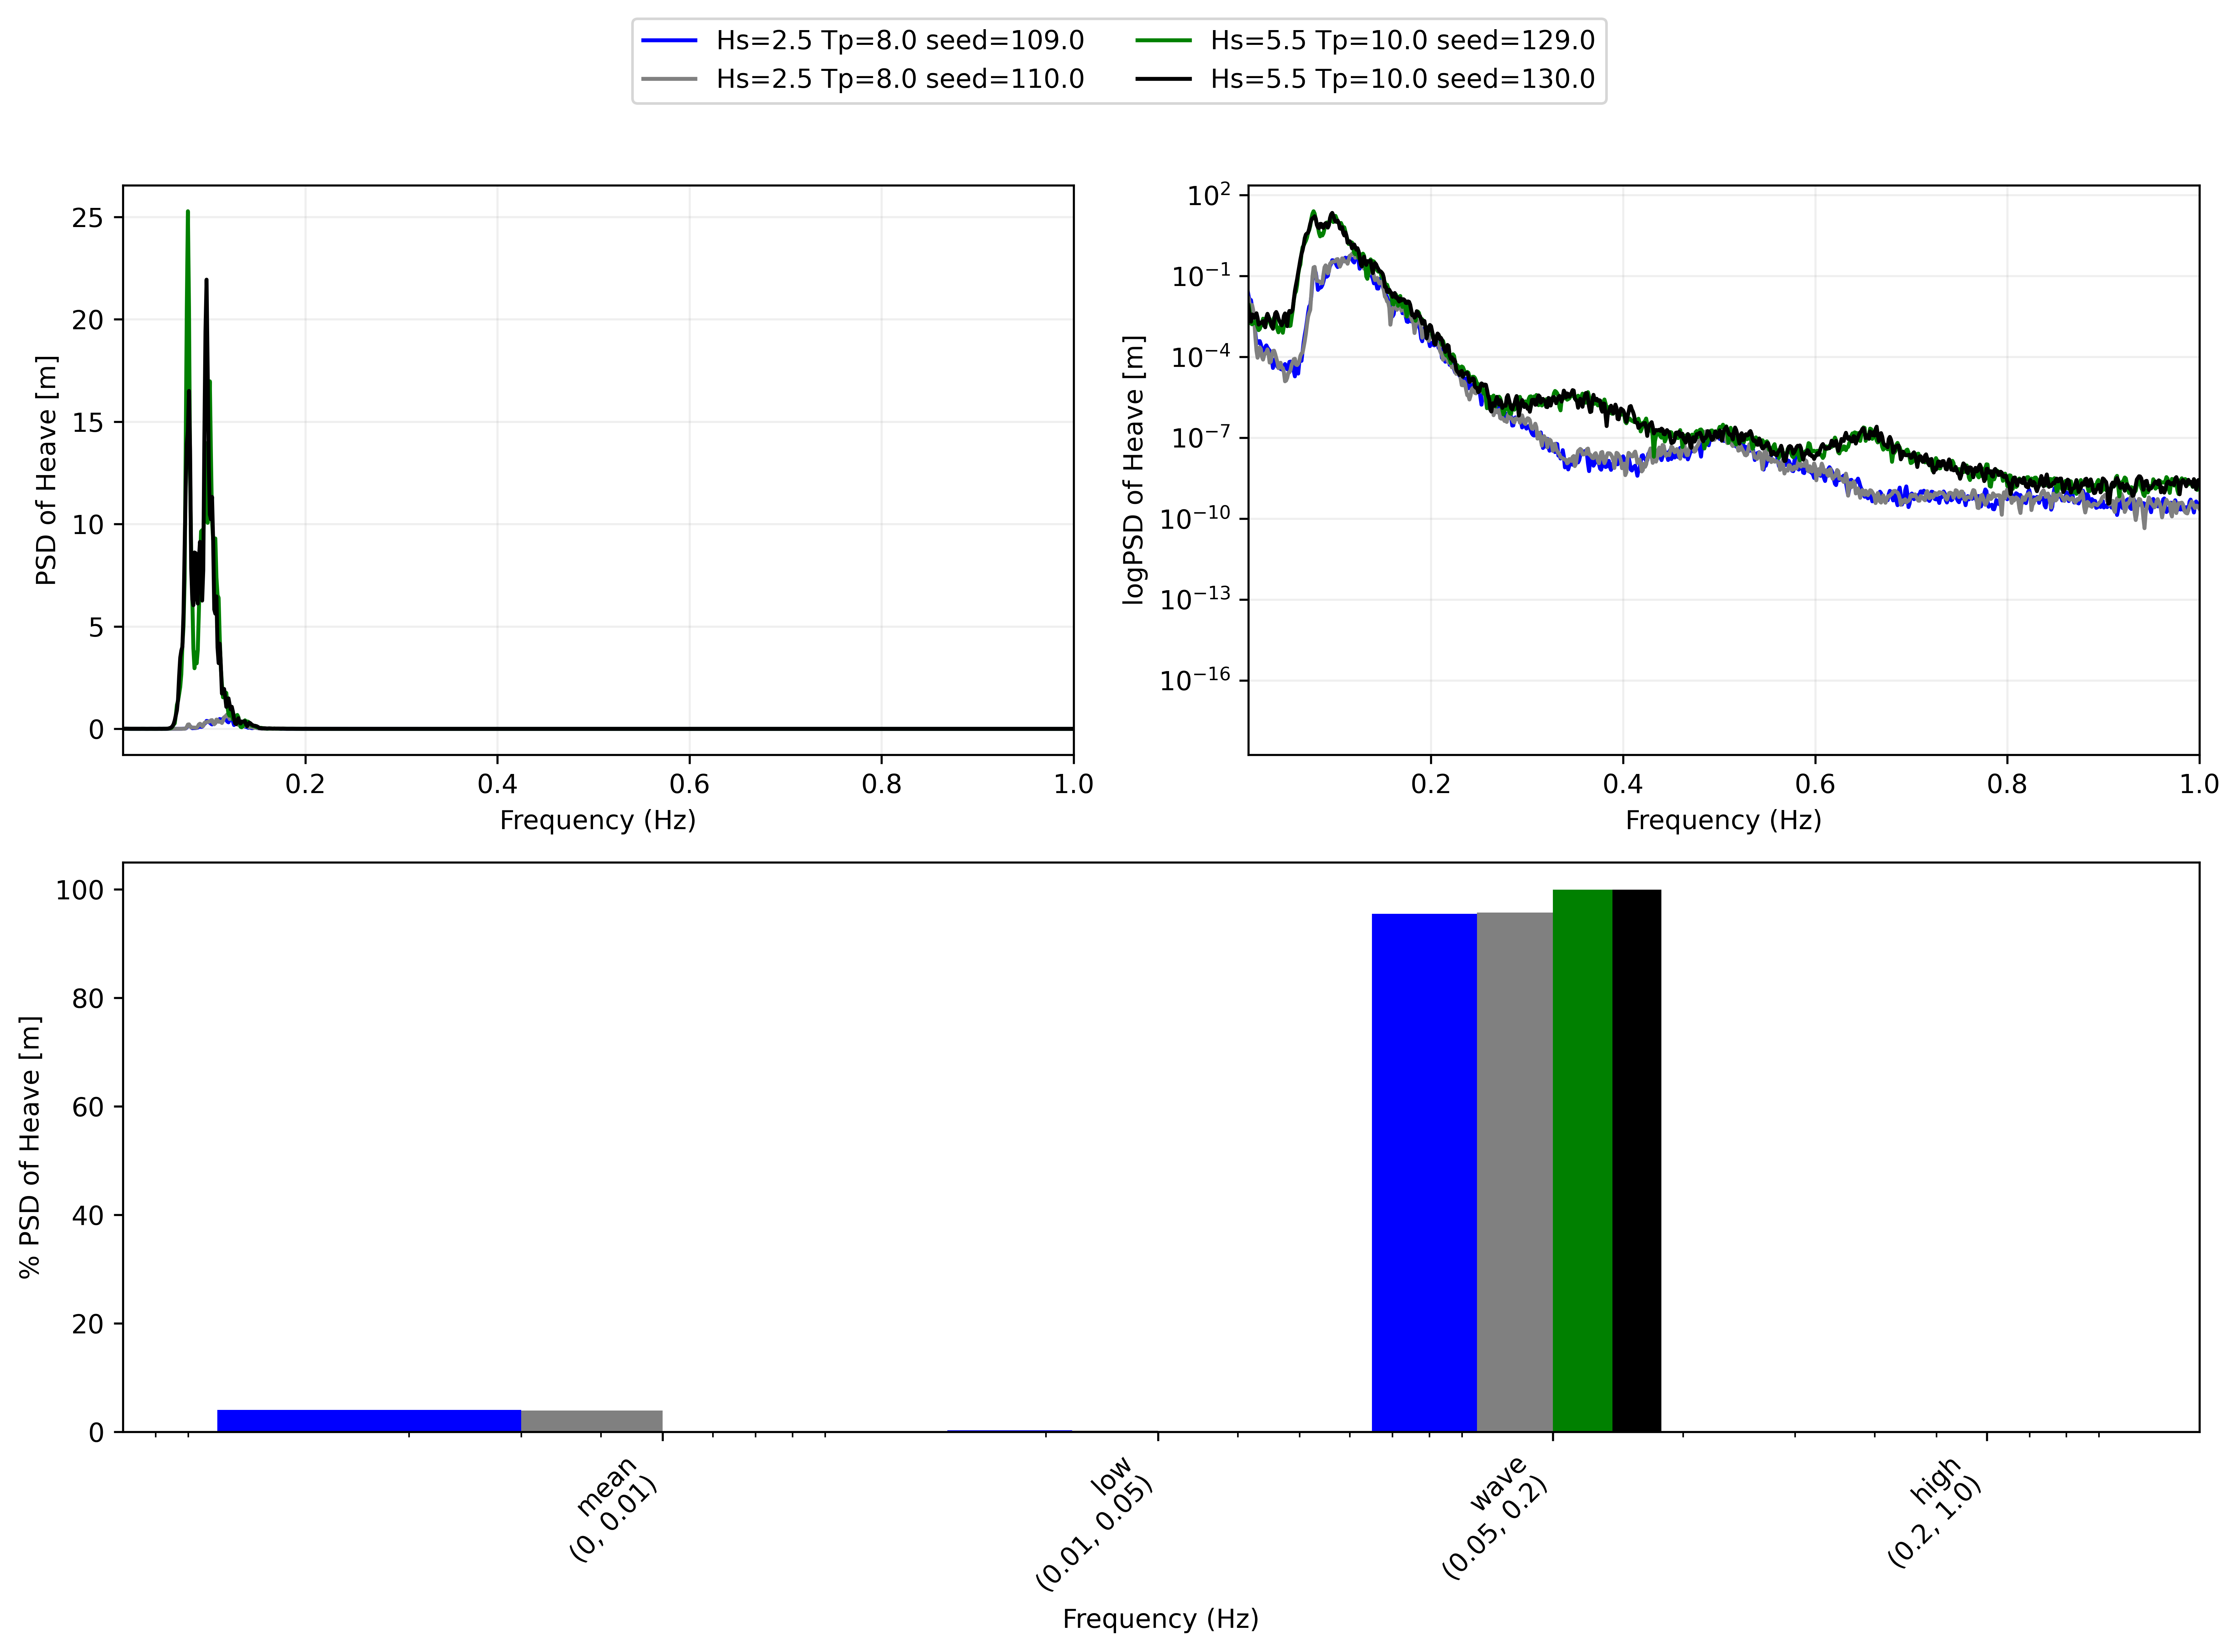

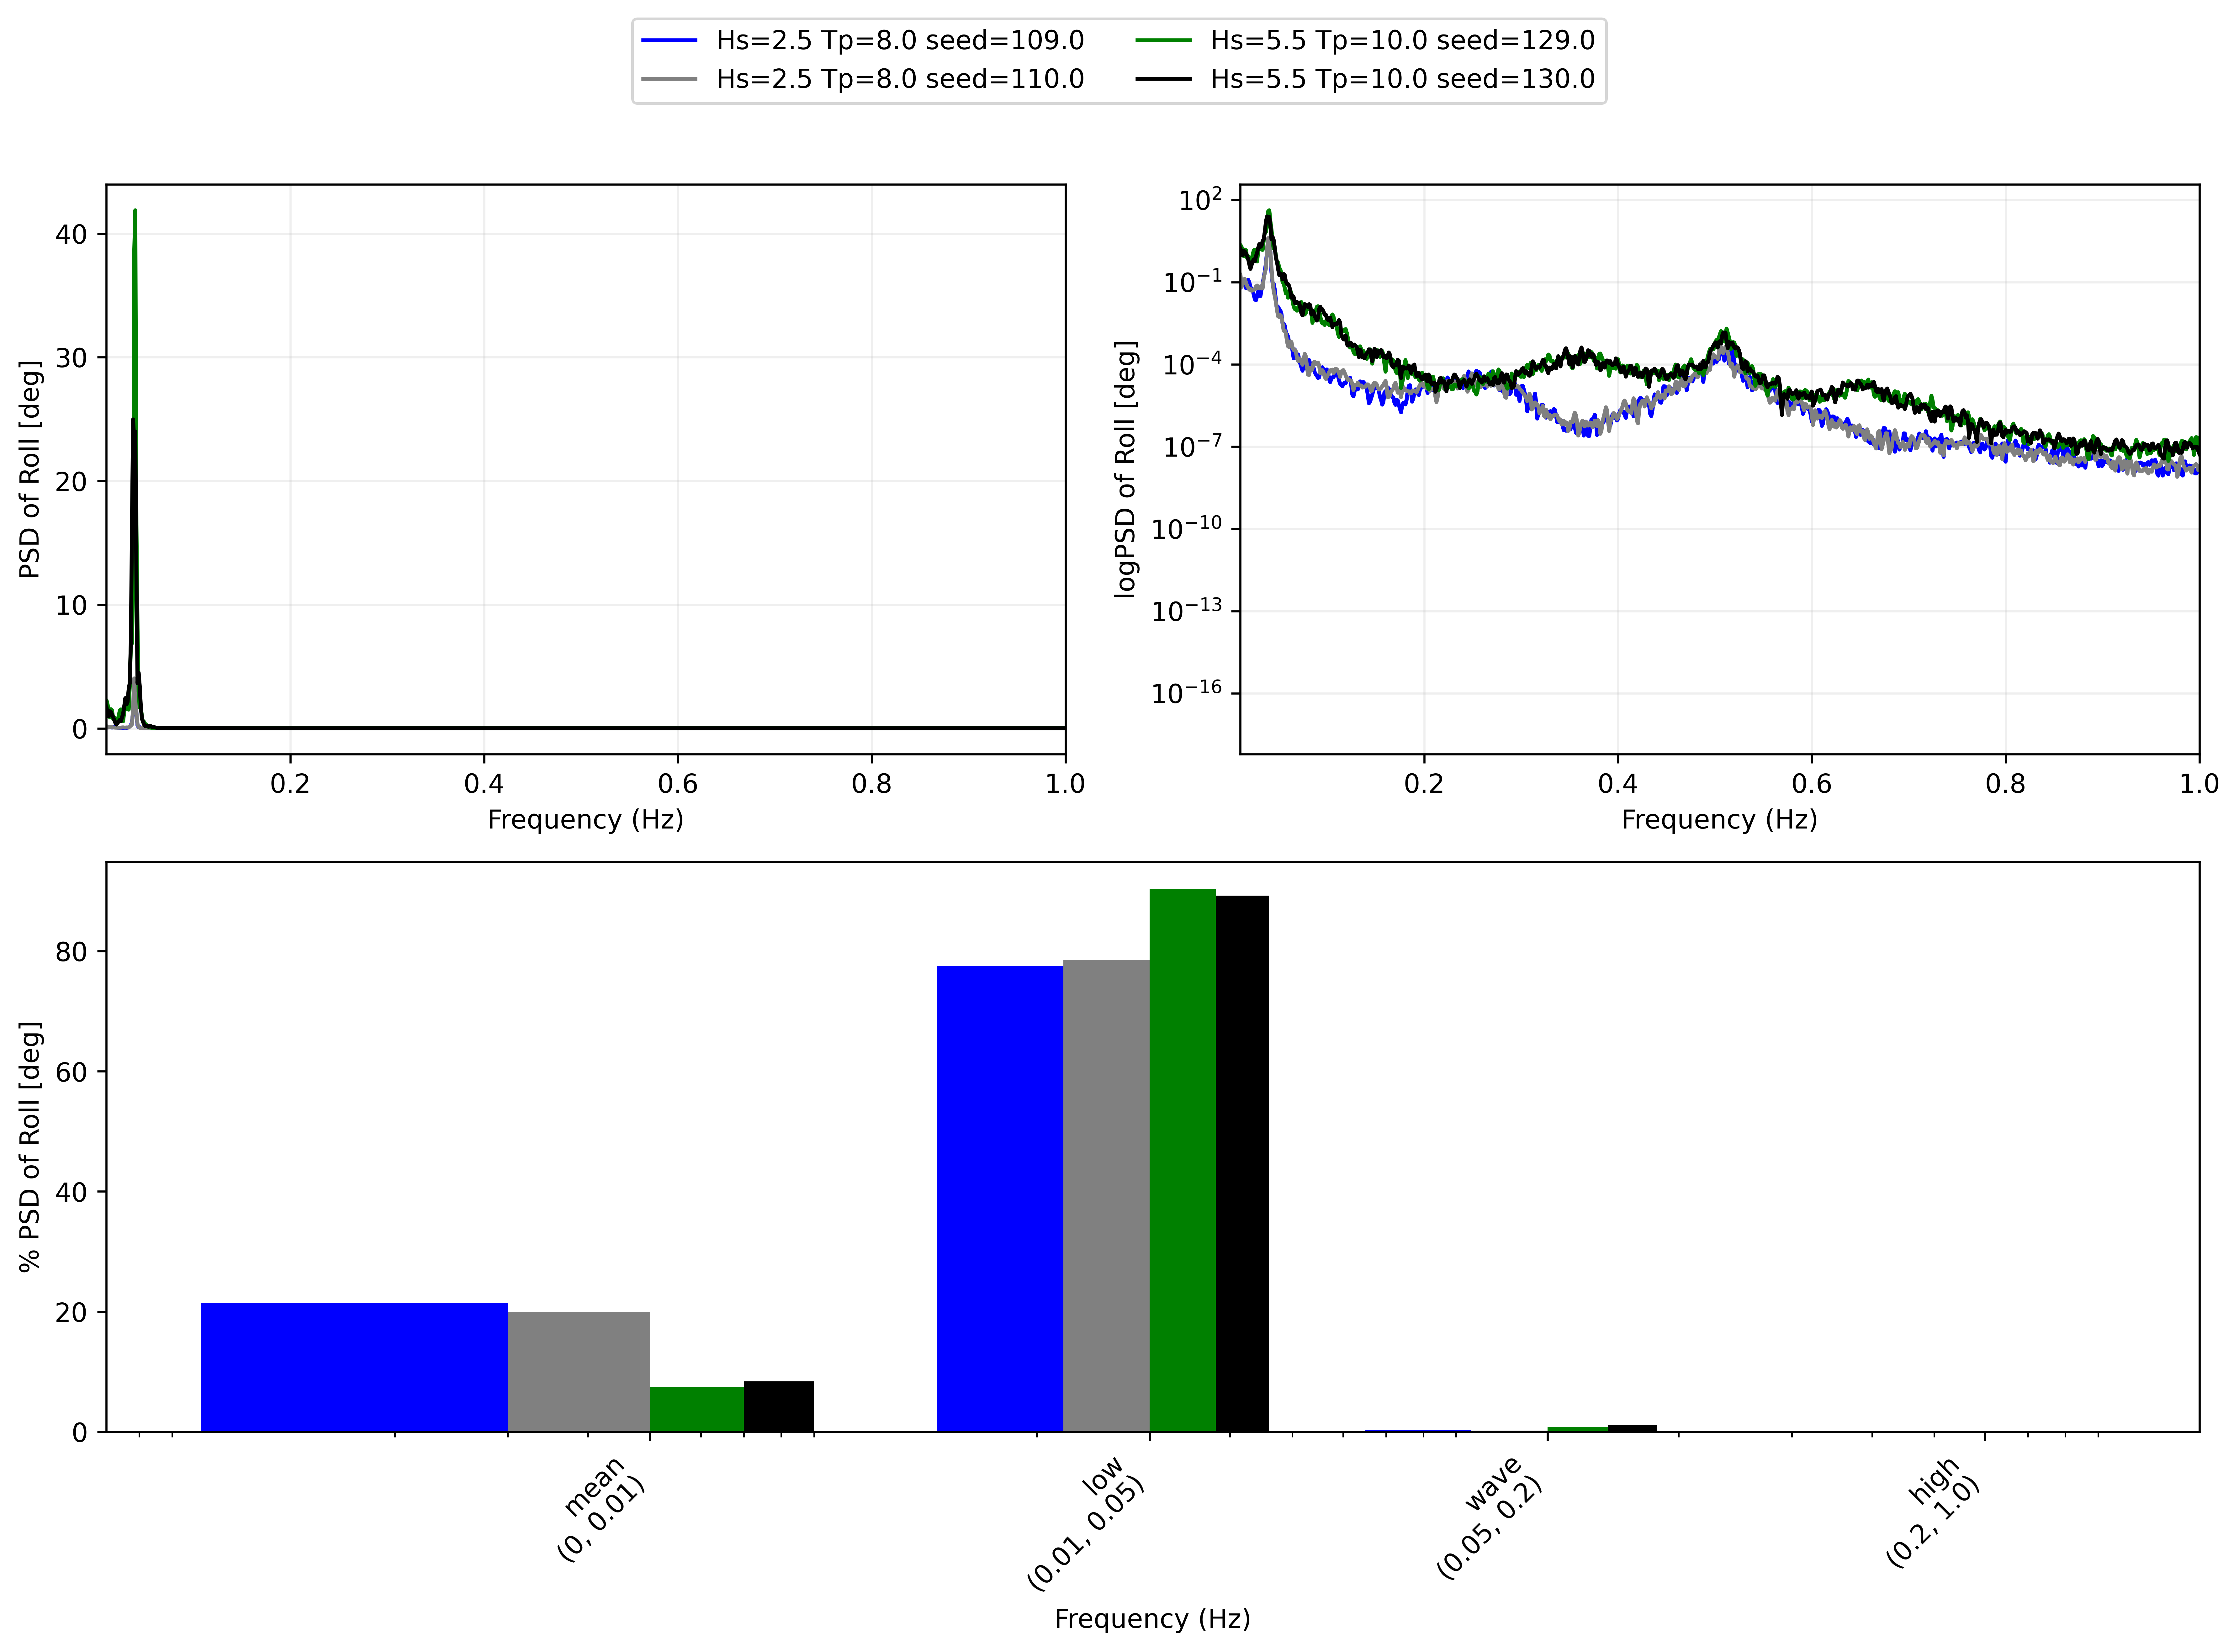

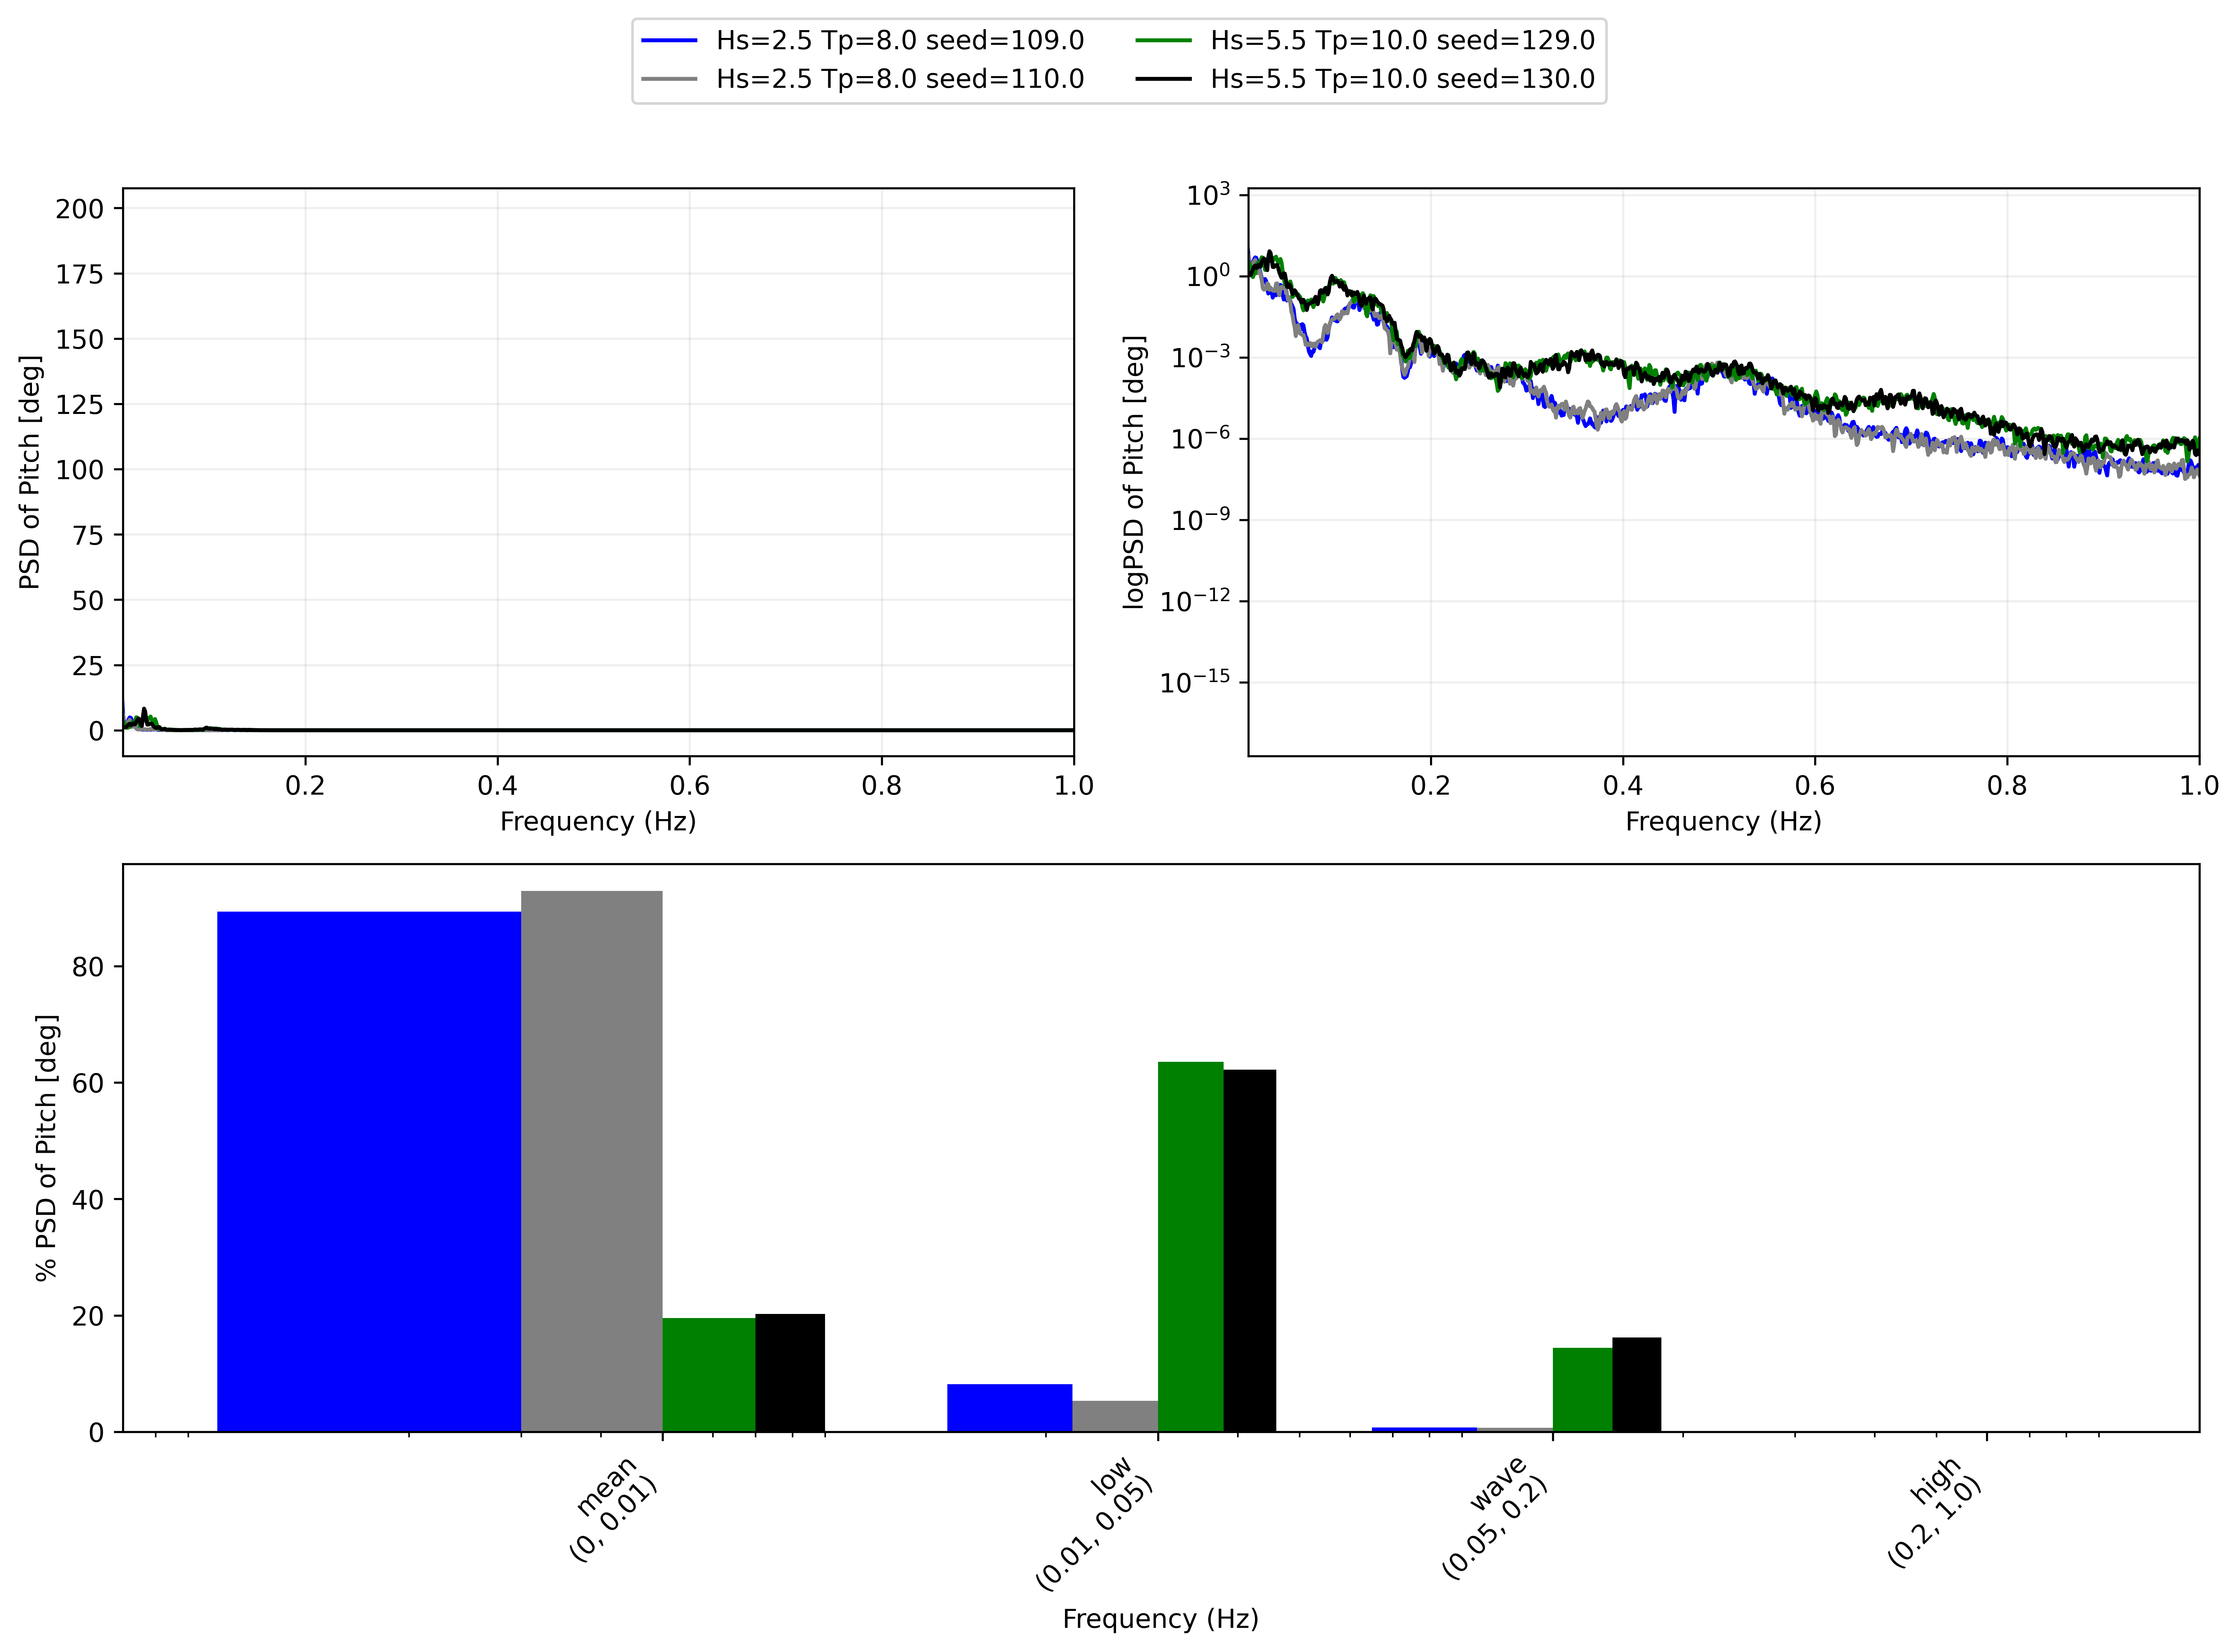

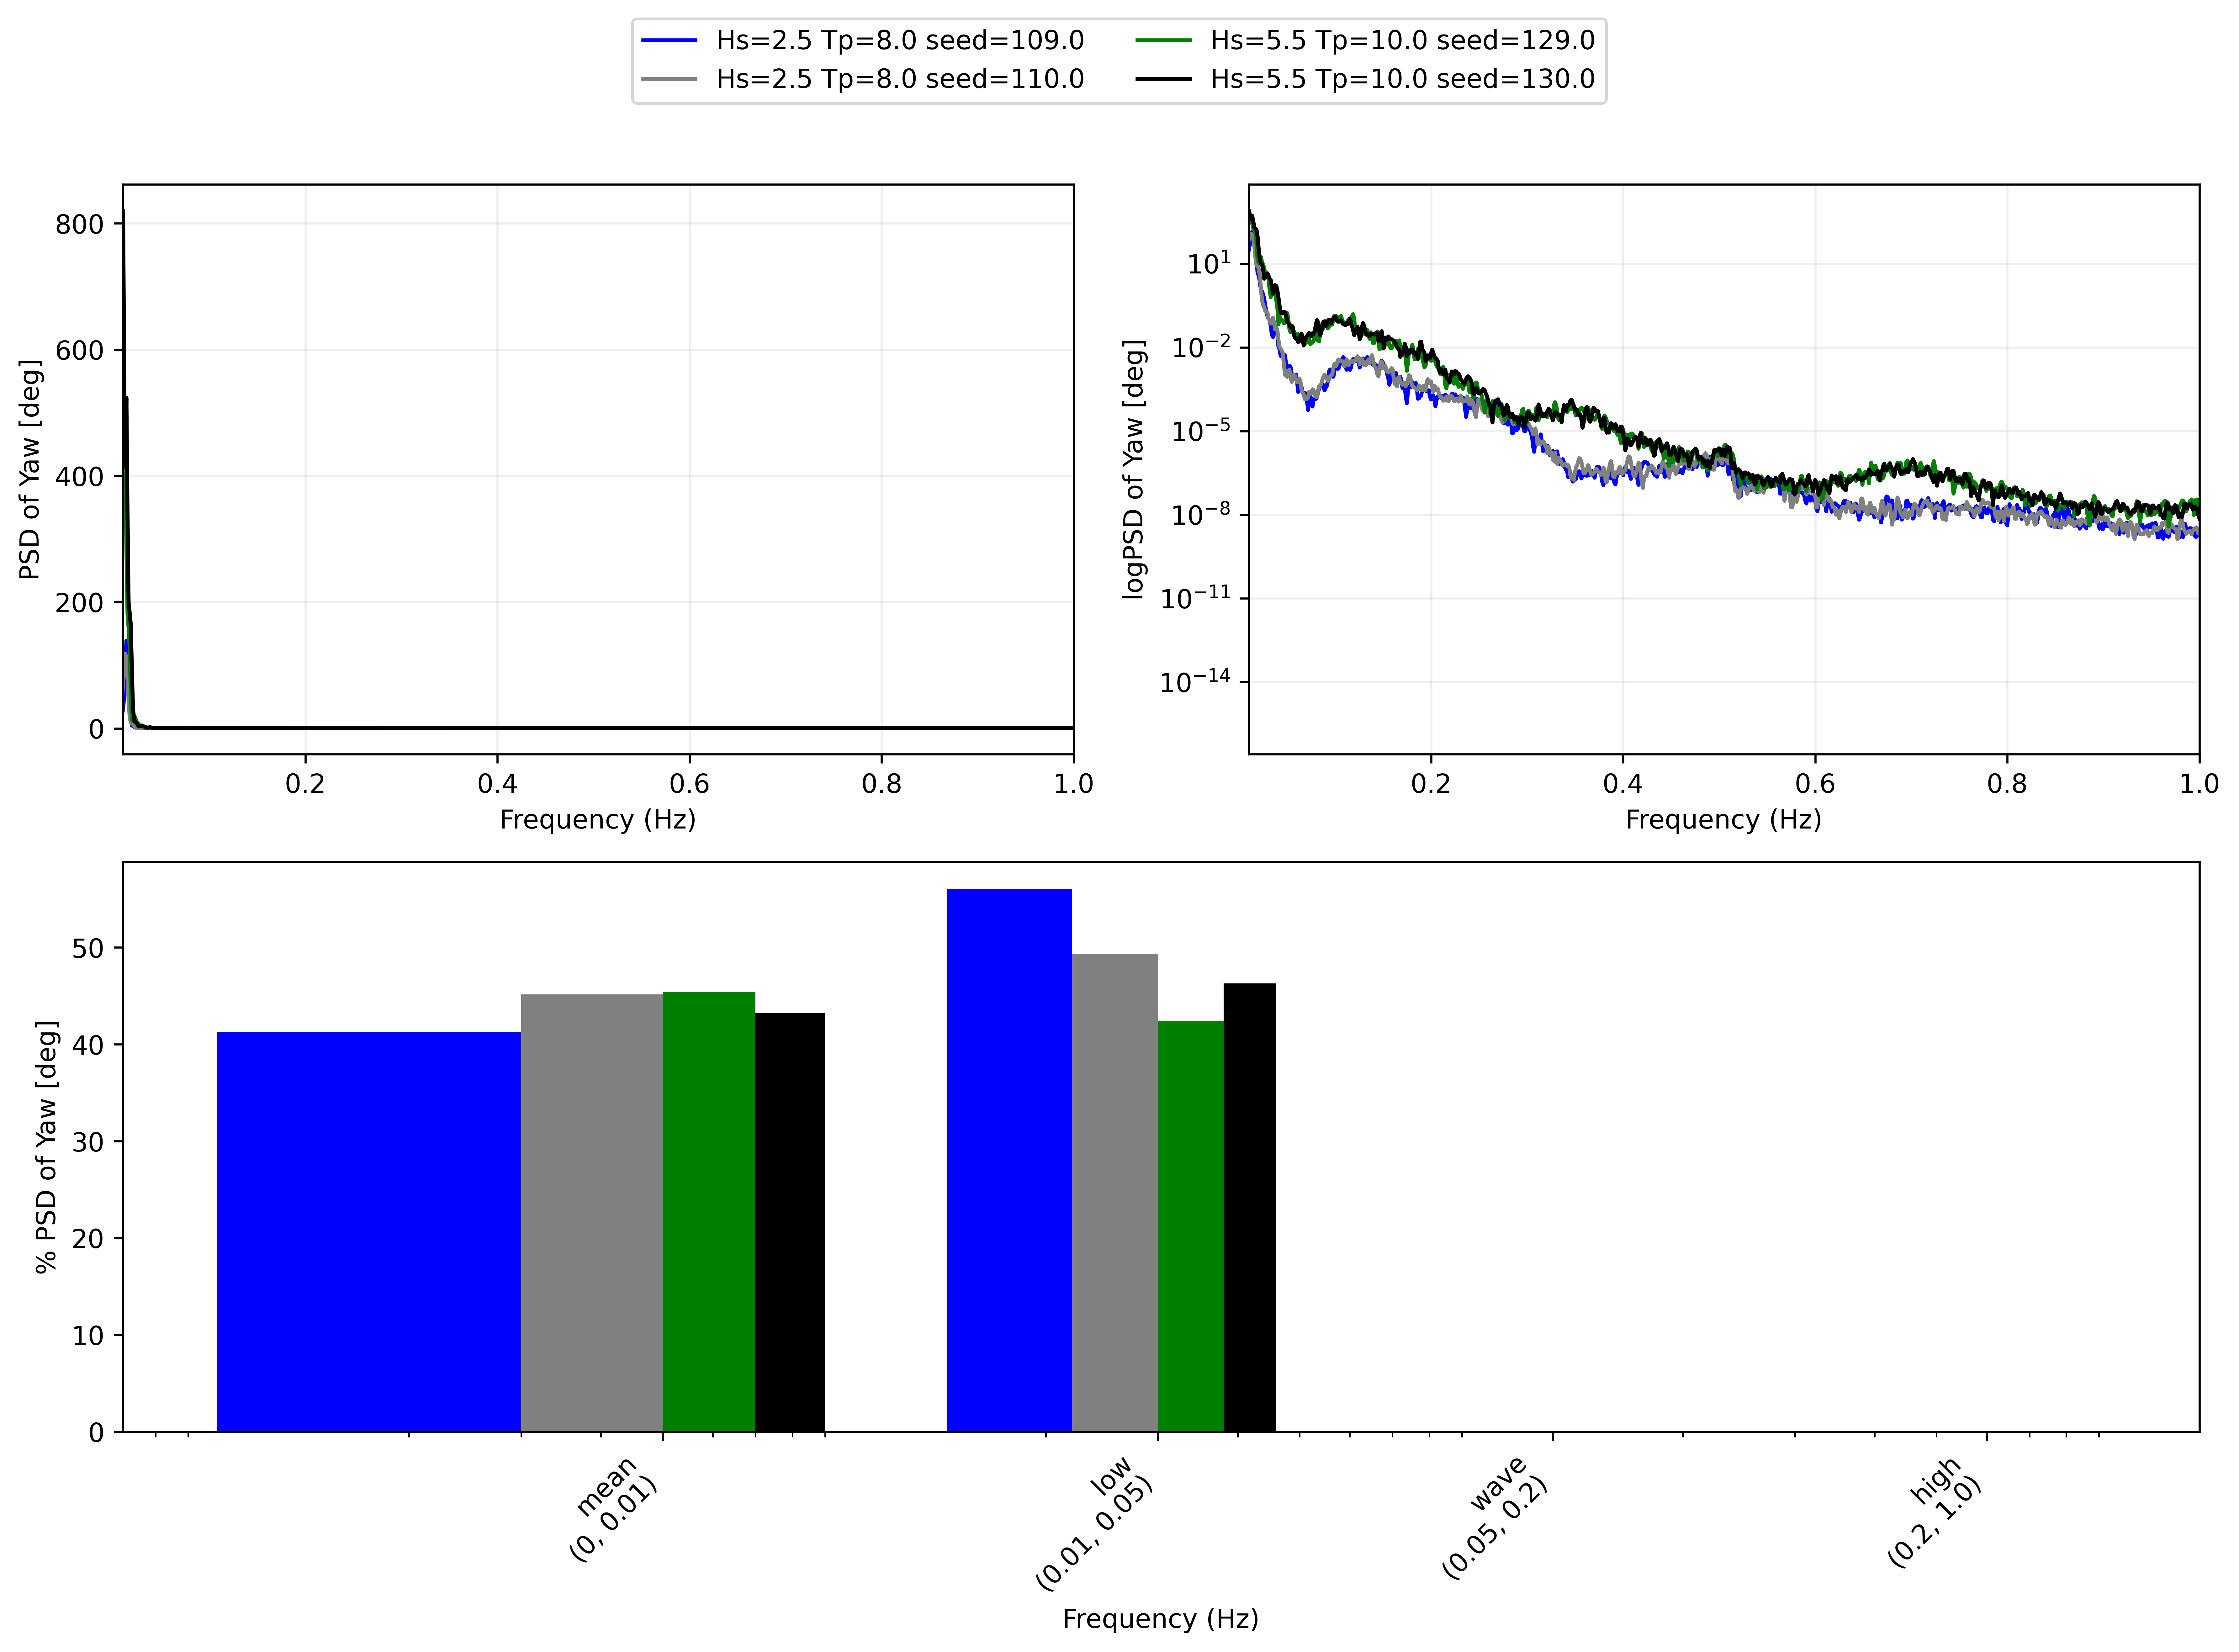

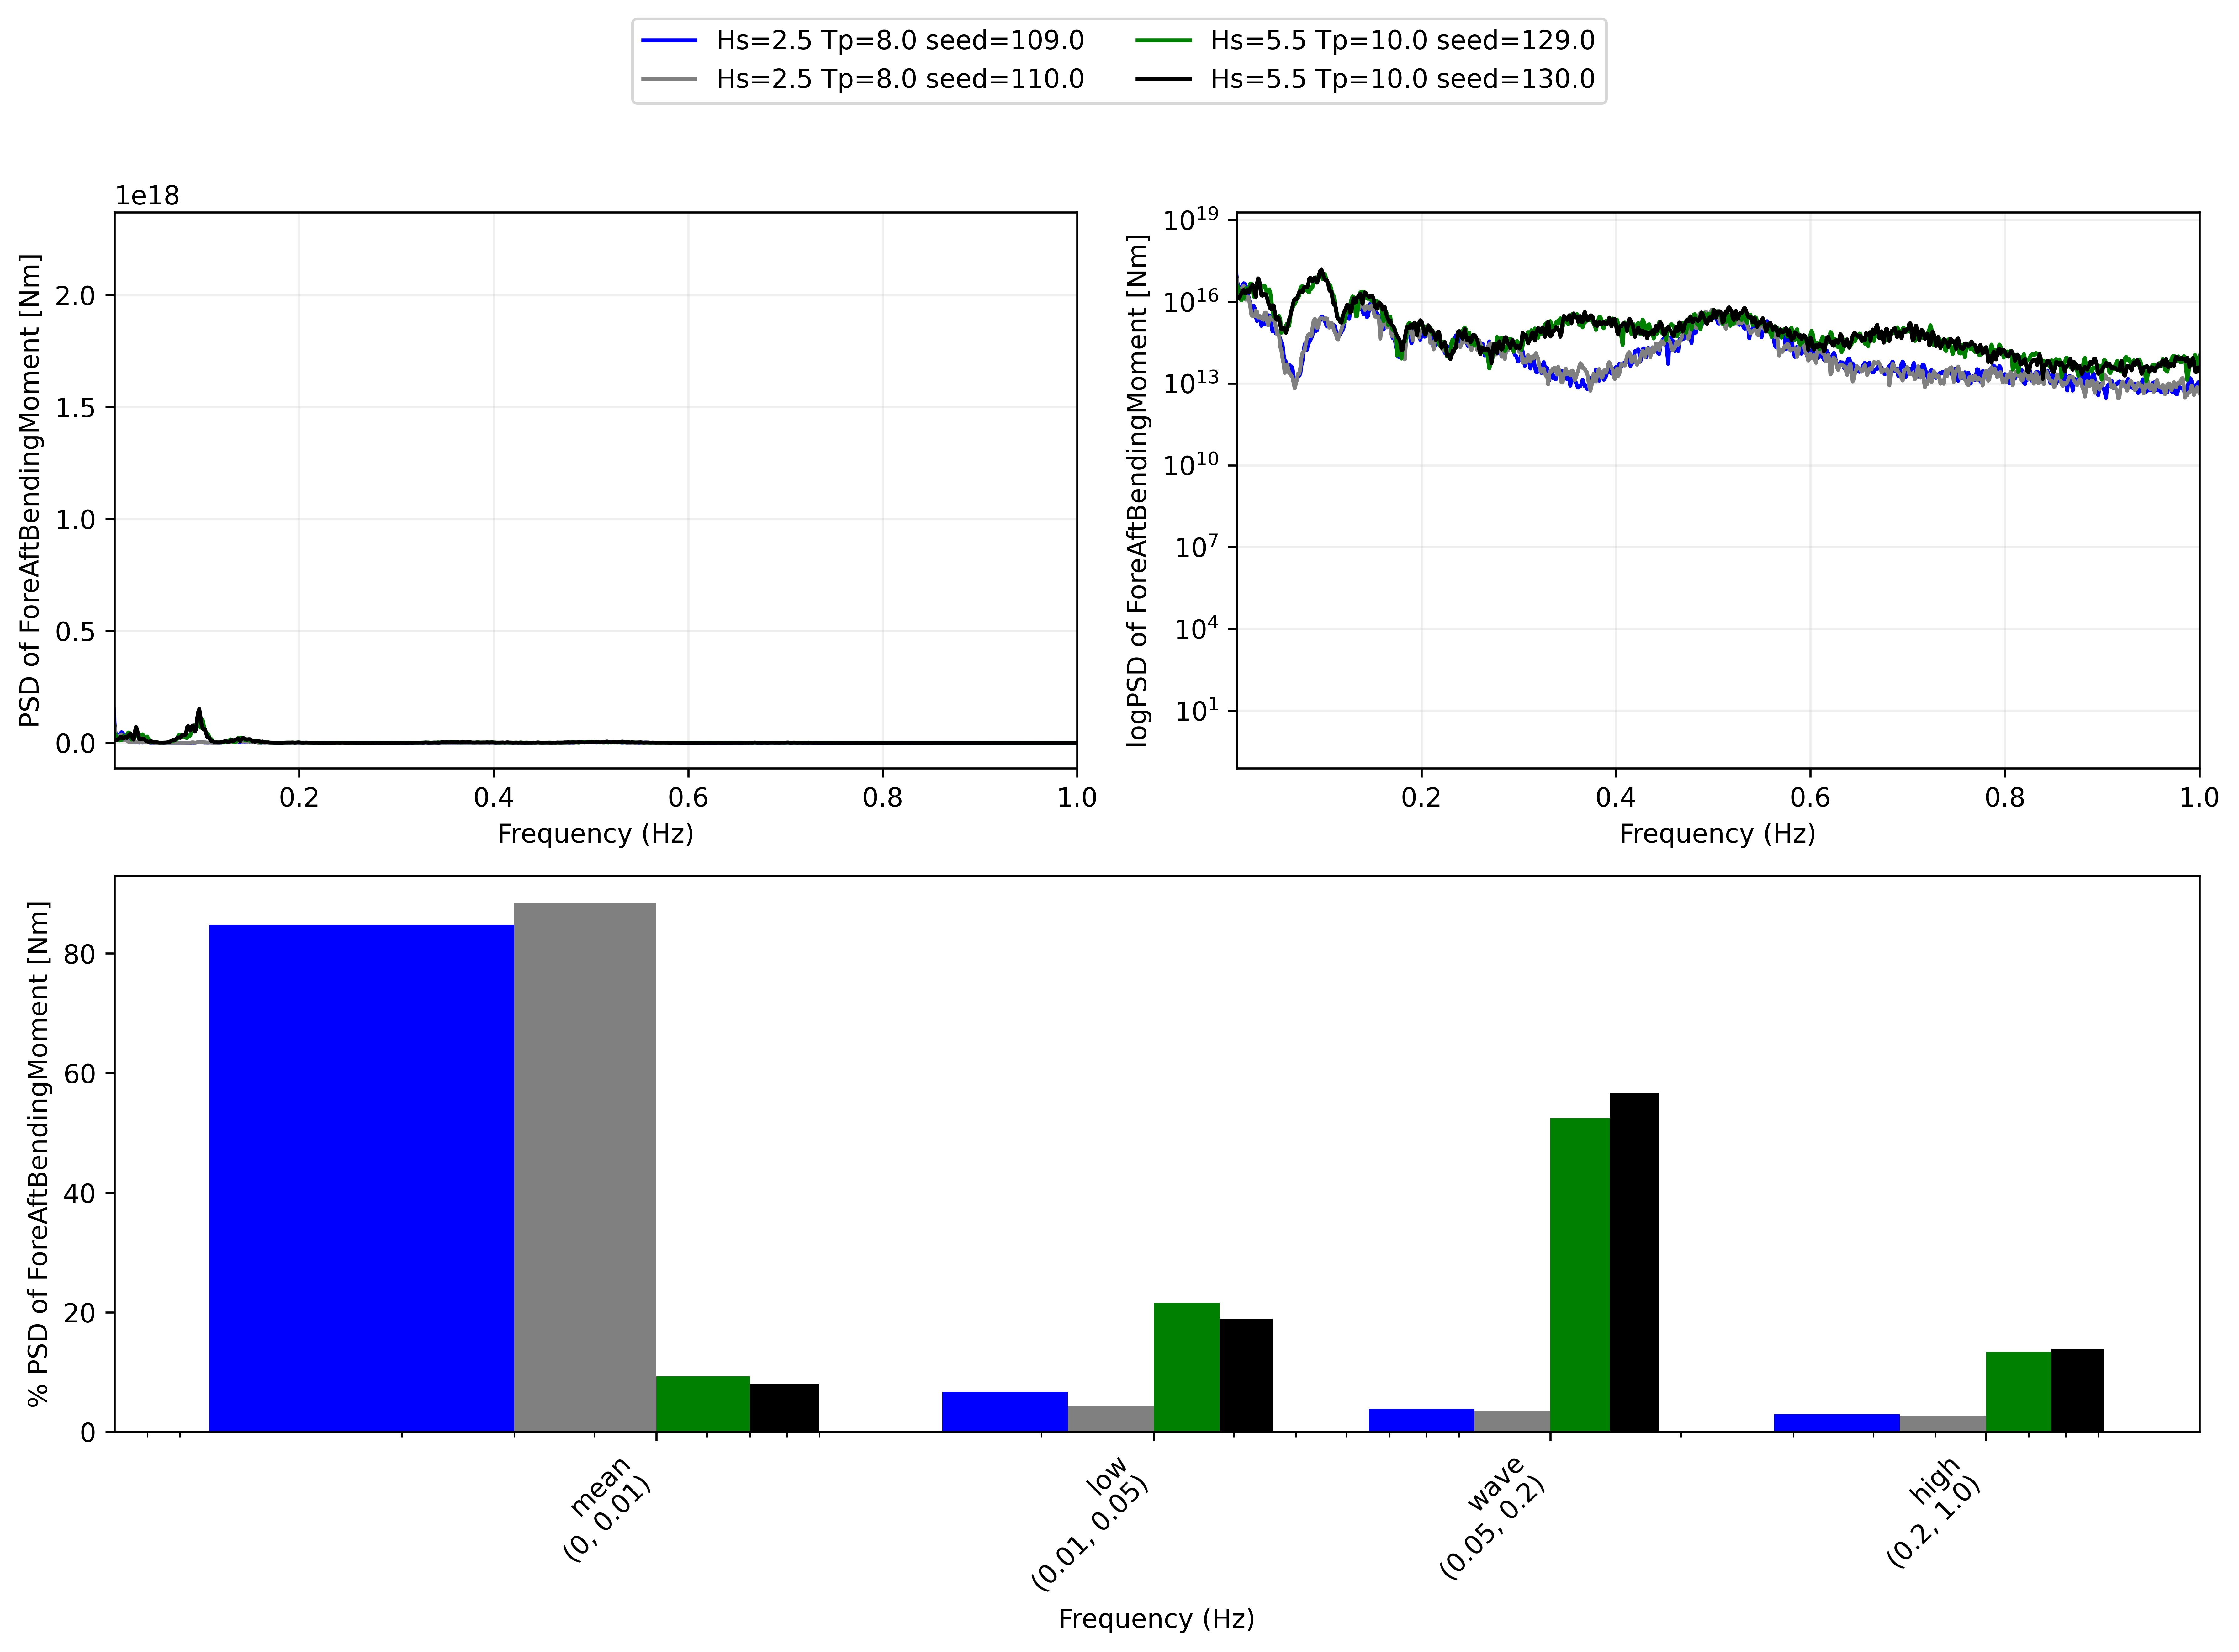

In [13]:
outputs = [
    'Surge [m]',
    'Sway [m]',
    'Heave [m]',
    'Roll [deg]',
    'Pitch [deg]',
    'Yaw [deg]',
    'ForeAftBendingMoment [Nm]'
]

dict_cond_colors = {
    'IrregularAnalysis_1':'blue',
    'IrregularAnalysis_2':'grey',
    'IrregularAnalysis_3':'green',
    'IrregularAnalysis_4':'black'
}

# Define the frequency bands and their labels
freq_bands = {
    'mean': (0, 0.01),
    'low': (0.01, 0.05),
    'wave': (0.05, 0.2),
    'high': (0.2, 1.0)
}

H1_perm = H1.skip_transient(500)
conds = H1_perm.conds
# Plot by cond
#------------------------------------------

for output in outputs:
    dict_cond_legend = {}
    for cond in conds:
        met = H1_perm.varying_metadata.sel({'condition':cond})
        dict_cond_legend[cond]='Hs=' + str(met['significantWaveHeight'].values[0]) + ' Tp=' + str(met['peakPeriod'].values[0]) + ' seed=' + str(met['Waveseed'].values[0])
    
    H1_perm.comparePlot_spectral('condition', {'model':'INO_OptiFLEX22MW_Baseline', 'analysis':'Dynamic'}, output, dict_coord_colors=dict_cond_colors, dict_coord_legend=dict_cond_legend)

# Mooring lines Analysis

## Tension along the line

In [ ]:
# load_list = [
#     r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Mann_Results.h5',
#     r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Kaimal_Results.h5',
#     r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Mann_Results.h5',
#     r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Kaimal_Results.h5',
# ]

load_list = [
    r'.\_ResultsH5\V03_timestorage0d05\angle_var_all_windstypes_8ms.h5',
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Kaimal_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Kaimal_Results.h5',
] 

load_list = [
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Kaimal_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Kaimal_Results.h5',
]


dynamic_keys = {
                'line1//segment_1//element_1//Axial force':'TensionTopChainL1 [N]',
                'line1//segment_2//element_1//Axial force':'TensionTopRopeL1 [N]',
                'line1//segment_3//element_1//Axial force':'TensionBottomRopeL1 [N]',
                'line1//segment_4//element_1//Axial force':'TensionBottomChainL1 [N]',
                # 'line2//segment_1//element_1//Axial force':'TensionTopChainL2 [N]',
                # 'line2//segment_2//element_1//Axial force':'TensionTopRopeL2 [N]',
                # 'line2//segment_3//element_1//Axial force':'TensionBottomRopeL2 [N]',
                # 'line2//segment_4//element_1//Axial force':'TensionBottomChainL2 [N]',
                # 'line3//segment_1//element_1//Axial force':'TensionTopChainL3 [N]',
                # 'line3//segment_2//element_1//Axial force':'TensionTopRopeL3 [N]',
                # 'line3//segment_3//element_1//Axial force':'TensionBottomRopeL3 [N]',
                # 'line3//segment_4//element_1//Axial force':'TensionBottomChainL3 [N]',
                }

H1 = merge_simh5([SIMHigh5(load_list[i],dynamic_keys, source="file", debug=True) for i in range(0,len(load_list))])

T_trans = 900
H1_perm = H1.skip_transient(T_trans)



### Statistical analysis

#### With respect to the condition, for one line

In [ ]:
outputs = [
    'TensionTopChainL1 [N]',
    'TensionTopRopeL1 [N]',
    'TensionBottomRopeL1 [N]',
    'TensionBottomChainL1 [N]'
]
conds = H1_perm.df.coords['condition'].values#[:2]
x_name = 'U_hub (m/s)'
x_vals = np.array([8,14])

print('create below a dictonary with the conditions associated with the correspondant value of x_val')
print('Here are the conditions : ')
print(conds)

In [ ]:
dict_cond_x = {'KaimalSet_1':8, 'KaimalSet_10':14, 'KaimalSet_11':14, 'KaimalSet_12':14, 'KaimalSet_2':8,
 'KaimalSet_3':8, 'KaimalSet_4':8, 'KaimalSet_5':8, 'KaimalSet_6':8, 'KaimalSet_7':14,
 'KaimalSet_8':14, 'KaimalSet_9':14, 'MannSet_1':8, 'MannSet_10':14, 'MannSet_11':14,
 'MannSet_12':14, 'MannSet_2':8, 'MannSet_3':8, 'MannSet_4':8, 'MannSet_5':8, 'MannSet_6':8,
 'MannSet_7':14, 'MannSet_8':14, 'MannSet_9':14}

dict_cond_colors = {'KaimalSet_1':'blue', 'KaimalSet_10':'blue', 'KaimalSet_11':'blue', 'KaimalSet_12':'blue', 'KaimalSet_2':'blue',
 'KaimalSet_3':'blue', 'KaimalSet_4':'blue', 'KaimalSet_5':'blue', 'KaimalSet_6':'blue', 'KaimalSet_7':'blue',
 'KaimalSet_8':'blue', 'KaimalSet_9':'blue', 'MannSet_1':'red', 'MannSet_10':'red', 'MannSet_11':'red',
 'MannSet_12':'red', 'MannSet_2':'red', 'MannSet_3':'red', 'MannSet_4':'red', 'MannSet_5':'red', 'MannSet_6':'red',
 'MannSet_7':'red', 'MannSet_8':'red', 'MannSet_9':'red'}

In [ ]:
fig,ax = plt.subplots(5,len(outputs), figsize=(30, 12), dpi=600)

leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond})
    leg.append(cond)
    for j, output in enumerate(outputs):
        # print('Mean of ' + output + ' =' + str(run[output].mean()))
        ax[0,j].plot(dict_cond_x[cond], run[output].mean(), color = dict_cond_colors[cond],marker='.')
        ax[0,j].set_xlabel(x_name)
        ax[0,j].set_ylabel('Mean of ' + output)

        ax[1,j].plot(dict_cond_x[cond], run[output].std(), color = dict_cond_colors[cond],marker='.')
        ax[1,j].set_xlabel(x_name)
        ax[1,j].set_ylabel('Std of ' + output)

        ax[2,j].plot(dict_cond_x[cond], run[output].quantile([0.9]), color = dict_cond_colors[cond],marker='.')
        ax[2,j].set_xlabel(x_name)
        ax[2,j].set_ylabel("90% quantile of " + output)

        ax[3,j].plot(dict_cond_x[cond], run[output].std()/run[output].mean() *100, color = dict_cond_colors[cond],marker='.')
        ax[3,j].set_xlabel(x_name)
        ax[3,j].set_ylabel('Normalized Std of ' + output)

        ax[4,j].plot(dict_cond_x[cond], run[output].quantile([0.9])/run[output].mean() *100, color = dict_cond_colors[cond],marker='.')
        ax[4,j].set_xlabel(x_name)
        ax[4,j].set_ylabel("Normalized 90% quantile of " + output)

#### With respect to the line, for one condition

In [ ]:
def plot_mooringline_stats_comparison(axs, res, width, lines_outputs, lines_colors):
    lines = list(lines_outputs.keys())
    
    x = np.array([1,2,3,4])
    sections = [
        'TopChain',
        'TopRope',
        'BotRope',
        'BotChain'
    ]

    for i in range(len(lines)):
        offset = i*width
        line = lines[i]
        vals = []
        outputs = lines_outputs[line]
        for output in outputs:
            mean, std, q90 = res[output].mean() , res[output].std() , res[output].quantile([0.90]).values[0]
            vals.append([mean, std/mean * 100, q90/mean * 100])
        vals = np.array(vals)

        diag0 = axs[0].barh(x+offset, vals[:,0], width, color=lines_colors[line])
        diag1 = axs[1].barh(x+offset, vals[:,1], width, color=lines_colors[line])
        diag2 = axs[2].barh(x+offset, vals[:,2], width, color=lines_colors[line])
    
        axs[0].set_yticks(x+3/2*width, sections)
        axs[0].bar_label(diag0, fmt= lambda y: f'{y:.2e}', label_type = 'center')
        axs[0].set_title('Mean for condition selected')

        axs[1].set_yticks(x+3/2*width, sections)
        axs[1].bar_label(diag1, fmt= lambda y: f'{y:.1f} %', label_type = 'center')
        axs[1].set_title('Normalized std for condition selected')


        axs[2].set_yticks(x+3/2*width, sections)
        axs[2].bar_label(diag2, fmt= lambda y: f'{y:.1f} %', label_type = 'center')
        axs[2].set_title('Normalized 90% quantile for condition selected')

In [ ]:
lines_outputs = {
    'L1':[
        'TensionTopChainL1 [N]',
        'TensionTopRopeL1 [N]',
        'TensionBottomRopeL1 [N]',
        'TensionBottomChainL1 [N]'
    ],
    'L2':[
        'TensionTopChainL2 [N]',
        'TensionTopRopeL2 [N]',
        'TensionBottomRopeL2 [N]',
        'TensionBottomChainL2 [N]'
    ],
    'L3':[
        'TensionTopChainL3 [N]',
        'TensionTopRopeL3 [N]',
        'TensionBottomRopeL3 [N]',
        'TensionBottomChainL3 [N]'
    ]
}
lines_colors = {
    'L1':'orange',
    'L2':'green',
    'L3':'red'
}

cond = H1_perm.df.coords['condition'].values[13]


fig,ax = plt.subplots(1,3, figsize=(15, 6), dpi=600)

run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond}, show=False)

plot_mooringline_stats_comparison(
    ax,
    run,
    0.25,
    lines_outputs,
    lines_colors
)
fig.suptitle(cond)
fig.legend(list(lines_outputs.keys()), ncol = 3, loc='upper center', bbox_to_anchor = (0.5,0))
fig.tight_layout()

### Spectral analysis

#### Overview

In [ ]:
outputs = [
    'TensionTopChainL1 [N]',
    'TensionTopRopeL1 [N]',
    #'TensionBottomRopeL1 [N]',
    #'TensionBottomChainL1 [N]'
]
conds = H1_perm.df.coords['condition'].values#[:2]

fig,ax = plt.subplots(2,len(outputs), figsize=(12, 8), dpi=600)

leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond})
    leg.append(cond)
    for j, output in enumerate(outputs):
        t, serie = run[output].index, np.array(run[output])
        dt = t[1]-t[0]
        f,Sp = PSD_wave4(serie, dt)

        ax[0,j].plot(f, Sp)#, color = dict_cond_colors[cond],marker='.')
        ax[0,j].set_xlabel('Frequency (Hz)')
        ax[0,j].set_ylabel('PSD of ' + output)
        ax[0,j].set_xlim(0.01,1)

        ax[1,j].semilogy(f, Sp)#, color = dict_cond_colors[cond],marker='.')
        ax[1,j].set_xlabel('Frequency (Hz)')
        ax[1,j].set_ylabel('PSD of ' + output)
        ax[1,j].set_xlim(0.01,1)

#### Distribution of energy

In [ ]:
# Chopping the frequency axis in intervals to get a distribution of normalized PSD
intervals = {
    'mean':(0,0.01),
    'low':(0.01,0.05),
    'waves':(0.05,0.2),
    'high':(0.2,10000)
}


In [ ]:
def plot_interval_distribution(ax, intervals, f, Sp, width, i_plot, color):
    Sp = Sp/np.sum(Sp) * 100
    offset = i_plot * width
    vals = []
    names = list(intervals.keys())
    x = np.array([i+offset for i in range(len(names))])
    for name in names:
        interval = intervals[name]
        fmin,fmax = max(f[0],interval[0]), min(f[-1],interval[1])
        i_freqs = np.logical_and(f>=fmin,f<=fmax)
        vals.append(np.sum(Sp[i_freqs]))
    diag = ax.barh(x, vals, width, color = color)
    ax.set_yticks(x-offset/2, names)
    ax.bar_label(diag, fmt= lambda x: f'{x:.1f} %')

In [ ]:
outputs = [
    'TensionTopChainL3 [N]',
    'TensionTopRopeL3 [N]',
    'TensionBottomRopeL3 [N]',
    'TensionBottomChainL3 [N]'
]
conds = list(H1_perm.df.coords['condition'].values[:3]) + list(H1_perm.df.coords['condition'].values[-3:])
print(conds)

dict_cond_colors = {'KaimalSet_1':'cyan', 'KaimalSet_10':'blue', 'KaimalSet_11':'blue', 'KaimalSet_12':'blue', 'KaimalSet_2':'cyan',
 'KaimalSet_3':'cyan', 'KaimalSet_4':'cyan', 'KaimalSet_5':'cyan', 'KaimalSet_6':'cyan', 'KaimalSet_7':'blue',
 'KaimalSet_8':'blue', 'KaimalSet_9':'blue', 'MannSet_1':'red', 'MannSet_10':'orange', 'MannSet_11':'orange',
 'MannSet_12':'orange', 'MannSet_2':'red', 'MannSet_3':'red', 'MannSet_4':'red', 'MannSet_5':'red', 'MannSet_6':'red',
 'MannSet_7':'orange', 'MannSet_8':'orange', 'MannSet_9':'orange'}

fig,ax = plt.subplots(2,2, figsize=(13,11), dpi=600)
ax = ax.flatten()
leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond}, show=False)
    leg.append(cond)
    for j, output in enumerate(outputs):
        t, serie = run[output].index, np.array(run[output])
        dt = t[1]-t[0]
        f,Sp = PSD_wave4(serie, dt)

        plot_interval_distribution(ax[j], intervals, f, Sp, 0.15, i, dict_cond_colors[cond])
        ax[j].set_title(output)
fig.legend(conds)
fig.tight_layout()

#### General analysis

In [ ]:
outputs = [
    'TensionTopChainL1 [N]',
    'TensionTopRopeL1 [N]',
    'TensionBottomRopeL1 [N]',
    'TensionBottomChainL1 [N]'
]

dict_cond_colors = {'KaimalSet_1':'cyan', 'KaimalSet_10':'blue', 'KaimalSet_11':'blue', 'KaimalSet_12':'blue', 'KaimalSet_2':'cyan',
 'KaimalSet_3':'cyan', 'KaimalSet_4':'cyan', 'KaimalSet_5':'cyan', 'KaimalSet_6':'cyan', 'KaimalSet_7':'blue',
 'KaimalSet_8':'blue', 'KaimalSet_9':'blue', 'MannSet_1':'red', 'MannSet_10':'orange', 'MannSet_11':'orange',
 'MannSet_12':'orange', 'MannSet_2':'red', 'MannSet_3':'red', 'MannSet_4':'red', 'MannSet_5':'red', 'MannSet_6':'red',
 'MannSet_7':'orange', 'MannSet_8':'orange', 'MannSet_9':'orange'}

# Define the frequency bands and their labels
freq_bands = {
    'mean': (0, 0.01),
    'low': (0.01, 0.05),
    'wave': (0.05, 0.2),
    'high': (0.2, 1.0)
}

H1_perm = H1.skip_transient(500)
conds = list(H1_perm.df.coords['condition'].values[:3]) + list(H1_perm.df.coords['condition'].values[-3:])
# Plot by cond
#------------------------------------------

for j, output in enumerate(outputs):
    dict_cond_legend = {}
    for cond in conds:
        met = H1_perm.varying_metadata.sel({'condition':cond})
        d = {
            'Hs':met['significantWaveHeight'].values[0],
            'Tp':met['peakPeriod'].values[0],
            'Uhub':met['windSpeed'].values[0],
            'type':cond[0:5]
            # 'seed':met['Waveseed'].values[0]
        }
        dict_cond_legend[cond]=d
    
    spectral_analysis(H1_perm, 'Baseline', output, dict_cond_colors, dict_cond_legend, freq_bands)

## Bottom contact

Since elements are bar elements, there is no stiffness for the parameters 

### Load datas

In [ ]:
load_list = [
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\BaselineV02_Kaimal_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Mann_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\FlexibleMBC1P5_Kaimal_Results.h5',
    r'.\_ResultsH5\V02_timestorage0d025\constantwindworkflow_Results.h5',
]

# load_list = [
#     # r'.\_ResultsH5\V03_timestorage0d05\testFlexibleMB300s.h5',
#     # r'.\_ResultsH5\V03_timestorage0d05\testBaseline300s.h5',
#     # r'.\_ResultsH5\V02_timestorage0d025\constantwindworkflow_Results.h5',
# ]

# dynamic_keys = {

#                 'line1//segment_4//node_1//Displacement in z - direction':'VerticalMotion_N1L1 [m]',
#                 'line1//segment_4//node_2//Displacement in z - direction':'VerticalMotion_N2L1 [m]',
#                 'line1//segment_4//node_3//Displacement in z - direction':'VerticalMotion_N3L1 [m]',
#                 'line1//segment_4//node_4//Displacement in z - direction':'VerticalMotion_N4L1 [m]',
#                 'line1//segment_4//node_5//Displacement in z - direction':'VerticalMotion_N5L1 [m]',
#                 'line1//segment_4//node_6//Displacement in z - direction':'VerticalMotion_N6L1 [m]',
#                 'line1//segment_4//node_7//Displacement in z - direction':'VerticalMotion_N7L1 [m]',
#                 'line1//segment_4//node_8//Displacement in z - direction':'VerticalMotion_N8L1 [m]',

#                 'line2//segment_4//node_1//Displacement in z - direction':'VerticalMotion_N1L2 [m]',
#                 'line2//segment_4//node_2//Displacement in z - direction':'VerticalMotion_N2L2 [m]',
#                 'line2//segment_4//node_3//Displacement in z - direction':'VerticalMotion_N3L2 [m]',
#                 'line2//segment_4//node_4//Displacement in z - direction':'VerticalMotion_N4L2 [m]',
#                 'line2//segment_4//node_5//Displacement in z - direction':'VerticalMotion_N5L2 [m]',
#                 'line2//segment_4//node_6//Displacement in z - direction':'VerticalMotion_N6L2 [m]',
#                 'line2//segment_4//node_7//Displacement in z - direction':'VerticalMotion_N7L2 [m]',
#                 'line2//segment_4//node_8//Displacement in z - direction':'VerticalMotion_N8L2 [m]',

#                 'line3//segment_4//node_1//Displacement in z - direction':'VerticalMotion_N1L3 [m]',
#                 'line3//segment_4//node_2//Displacement in z - direction':'VerticalMotion_N2L3 [m]',
#                 'line3//segment_4//node_3//Displacement in z - direction':'VerticalMotion_N3L3 [m]',
#                 'line3//segment_4//node_4//Displacement in z - direction':'VerticalMotion_N4L3 [m]',
#                 'line3//segment_4//node_5//Displacement in z - direction':'VerticalMotion_N5L3 [m]',
#                 'line3//segment_4//node_6//Displacement in z - direction':'VerticalMotion_N6L3 [m]',
#                 'line3//segment_4//node_7//Displacement in z - direction':'VerticalMotion_N7L3 [m]',
#                 'line3//segment_4//node_8//Displacement in z - direction':'VerticalMotion_N8L3 [m]',

#                 }


dynamic_keys = {

                'line1//segment_4//element_1//Normal contact force per length - End 1':'NormalBottomForceE1L1 [N]',
                'line1//segment_4//element_2//Normal contact force per length - End 1':'NormalBottomForceE2L1 [N]',
                'line1//segment_4//element_3//Normal contact force per length - End 1':'NormalBottomForceE3L1 [N]',
                'line1//segment_4//element_4//Normal contact force per length - End 1':'NormalBottomForceE4L1 [N]',
                'line1//segment_4//element_5//Normal contact force per length - End 1':'NormalBottomForceE5L1 [N]',
                'line1//segment_4//element_6//Normal contact force per length - End 1':'NormalBottomForceE6L1 [N]',
                'line1//segment_4//element_7//Normal contact force per length - End 1':'NormalBottomForceE7L1 [N]',

                'line2//segment_4//element_1//Normal contact force per length - End 1':'NormalBottomForceE1L2 [N]',
                'line2//segment_4//element_2//Normal contact force per length - End 1':'NormalBottomForceE2L2 [N]',
                'line2//segment_4//element_3//Normal contact force per length - End 1':'NormalBottomForceE3L2 [N]',
                'line2//segment_4//element_4//Normal contact force per length - End 1':'NormalBottomForceE4L2 [N]',
                'line2//segment_4//element_5//Normal contact force per length - End 1':'NormalBottomForceE5L2 [N]',
                'line2//segment_4//element_6//Normal contact force per length - End 1':'NormalBottomForceE6L2 [N]',
                'line2//segment_4//element_7//Normal contact force per length - End 1':'NormalBottomForceE7L2 [N]',

                'line3//segment_4//element_1//Normal contact force per length - End 1':'NormalBottomForceE1L3 [N]',
                'line3//segment_4//element_2//Normal contact force per length - End 1':'NormalBottomForceE2L3 [N]',
                'line3//segment_4//element_3//Normal contact force per length - End 1':'NormalBottomForceE3L3 [N]',
                'line3//segment_4//element_4//Normal contact force per length - End 1':'NormalBottomForceE4L3 [N]',
                'line3//segment_4//element_5//Normal contact force per length - End 1':'NormalBottomForceE5L3 [N]',
                'line3//segment_4//element_6//Normal contact force per length - End 1':'NormalBottomForceE6L3 [N]',
                'line3//segment_4//element_7//Normal contact force per length - End 1':'NormalBottomForceE7L3 [N]',

}

H1 = merge_simh5([SIMHigh5(load_list[i],dynamic_keys, source="file") for i in range(0,len(load_list))])

T_trans = 900
H1_perm = H1.skip_transient(T_trans)



#### Timeserie

In [ ]:
outputs = [
    'VerticalMotion_N5L1 [m]',
    'VerticalMotion_N5L2 [m]',
    'VerticalMotion_N5L3 [m]',
]
cond = H1_perm.df.coords['condition'].values[0]
fig,ax = plt.subplots(len(outputs),1, figsize=(8, 12), dpi=600)

for j,output in enumerate(outputs):
    time, serie = H1.timeserie({'model':'FlexibleMB_C1P5', 'condition':cond, 'analysis':'Dynamic'}, output)
    ax[j].plot(time, serie)
    ax[j].set_title('Condition : ' + cond)
    ax[j].set_xlabel('Time (s)')
    ax[j].set_ylabel(output)

fig.tight_layout()

#### Statistical analysis

In [ ]:
def plot_bottomchain_stats_comparison(axs, x, res, lines_outputs, lines_colors, ls = '-'):
    lines = list(lines_outputs.keys())

    for i in range(len(lines)):
        line = lines[i]
        vals = []
        outputs = lines_outputs[line]
        for output in outputs:
            mean, std = res[output].mean() , res[output].std()
            vals.append([mean, std/mean * 100])
        vals = np.array(vals)

        diag0 = axs[0].plot(x, vals[:,0], color=lines_colors[line], ls = ls)
        diag1 = axs[1].plot(x, vals[:,1], color=lines_colors[line], ls = ls)
    
        axs[0].set_title('Mean for condition selected')
        axs[1].set_title('Normalized std for condition selected')
        axs[1].set_ylim(0,100)

In [ ]:
# x = ['N'+str(i) for i in range(1,7)]
x = ['E'+str(i) for i in range(1,8)]

lines_outputs = {
    'L1':[
        'NormalBottomForceE1L1 [N]',
        'NormalBottomForceE2L1 [N]',
        'NormalBottomForceE3L1 [N]',
        'NormalBottomForceE4L1 [N]',
        'NormalBottomForceE5L1 [N]',
        'NormalBottomForceE6L1 [N]',
        'NormalBottomForceE7L1 [N]',
    ],
    'L2':[
        'NormalBottomForceE1L2 [N]',
        'NormalBottomForceE2L2 [N]',
        'NormalBottomForceE3L2 [N]',
        'NormalBottomForceE4L2 [N]',
        'NormalBottomForceE5L2 [N]',
        'NormalBottomForceE6L2 [N]',
        'NormalBottomForceE7L2 [N]',
    ],
    'L3':[
        'NormalBottomForceE1L3 [N]',
        'NormalBottomForceE2L3 [N]',
        'NormalBottomForceE3L3 [N]',
        'NormalBottomForceE4L3 [N]',
        'NormalBottomForceE5L3 [N]',
        'NormalBottomForceE6L3 [N]',
        'NormalBottomForceE7L3 [N]',
    ]
}

# lines_outputs = {
#     'L1':[
#         'VerticalMotion_N1L1 [m]',
#         'VerticalMotion_N2L1 [m]',
#         'VerticalMotion_N3L1 [m]',
#         'VerticalMotion_N4L1 [m]',
#         'VerticalMotion_N5L1 [m]',
#         'VerticalMotion_N6L1 [m]',
#     ],
#     'L2':[
#         'VerticalMotion_N1L2 [m]',
#         'VerticalMotion_N2L2 [m]',
#         'VerticalMotion_N3L2 [m]',
#         'VerticalMotion_N4L2 [m]',
#         'VerticalMotion_N5L2 [m]',
#         'VerticalMotion_N6L2 [m]',
#     ],
#     'L3':[
#         'VerticalMotion_N1L3 [m]',
#         'VerticalMotion_N2L3 [m]',
#         'VerticalMotion_N3L3 [m]',
#         'VerticalMotion_N4L3 [m]',
#         'VerticalMotion_N5L3 [m]',
#         'VerticalMotion_N6L3 [m]',
#     ]
# }

lines_colors = {
    'L1':'orange',
    'L2':'green',
    'L3':'red'
}

# conds = [H1_perm.df.coords['condition'].values[0], H1_perm.df.coords['condition'].values[1], H1_perm.df.coords['condition'].values[13]]
conds = [H1_perm.df.coords['condition'].values[2],H1_perm.df.coords['condition'].values[4],H1_perm.df.coords['condition'].values[16]]

ls_conds = {
    conds[0]:'-',
    conds[1]:':',
    conds[2]:'--',
}

fig,ax = plt.subplots(2,1, figsize=(8,8), dpi=600)

for cond in conds :
    run, var = H1.extract_run({'model':'FlexibleMB_C1P5', 'analysis':'Dynamic', 'condition':cond}, show=True)
    plot_bottomchain_stats_comparison(
        ax,
        x,
        run,
        lines_outputs,
        lines_colors,
        ls = ls_conds[cond]
    )


legend = [
    line + '_' + cond for cond in conds for line in list(lines_outputs.keys())
]
print(legend)
fig.legend(legend, ncol = 3, loc='upper center', bbox_to_anchor = (0.5,0))
fig.tight_layout()

#### Spectral analysis

In [ ]:
H1_perm = H1.skip_transient(1100)
H1_perm.conds

In [ ]:
outputs = [
    'VerticalMotion_N7L1 [m]',
    'VerticalMotion_N6L1 [m]'
]
conds = H1_perm.df.coords['condition'].values#[:2]

# dict_cond_colors = {'KaimalSet_1':'cyan', 'KaimalSet_10':'blue', 'KaimalSet_11':'blue', 'KaimalSet_12':'blue', 'KaimalSet_2':'cyan',
#  'KaimalSet_3':'cyan', 'KaimalSet_4':'cyan', 'KaimalSet_5':'cyan', 'KaimalSet_6':'cyan', 'KaimalSet_7':'blue',
#  'KaimalSet_8':'blue', 'KaimalSet_9':'blue', 'MannSet_1':'red', 'MannSet_10':'orange', 'MannSet_11':'orange',
#  'MannSet_12':'orange', 'MannSet_2':'red', 'MannSet_3':'red', 'MannSet_4':'red', 'MannSet_5':'red', 'MannSet_6':'red',
#  'MannSet_7':'orange', 'MannSet_8':'orange', 'MannSet_9':'orange', 'ConstantSet_1':'grey', 'ConstantSet_2':'grey', 'ConstantSet_3':'black', 'ConstantSet_4':'black'
# }

dict_cond_colors = {
    'BottomDamping_1':'blue', 
    'BottomDamping_2':'green', 
    'BottomDamping_3':'orange', 
 
}

fig,ax = plt.subplots(2,len(outputs), figsize=(15, 8), dpi=600)

leg = []
for i, cond in enumerate(conds):
    run, var = H1_perm.extract_run({'model':'Baseline', 'analysis':'Dynamic', 'condition':cond}, show = False)
    leg.append(cond)
    for j, output in enumerate(outputs):
        t, serie = run[output].index, np.array(run[output])
        dt = t[1]-t[0]
        f,Sp = PSD_wave4(serie, dt)

        ax[0,j].plot(f, Sp, color = dict_cond_colors[cond])
        ax[0,j].set_xlabel('Frequency (Hz)')
        ax[0,j].set_ylabel('PSD of ' + output)
        ax[0,j].set_xlim(0.01,1)

        ax[1,j].semilogy(f, Sp, color = dict_cond_colors[cond])
        ax[1,j].set_xlabel('Frequency (Hz)')
        ax[1,j].set_ylabel('logPSD of ' + output)
        ax[1,j].set_xlim(0.01,1)
fig.legend(conds, ncol = 6, loc = 'upper center', bbox_to_anchor = (0.5, 1.0 ))